# Model figures for all populations

## Import and define functions
[back to top](#Summarize-models)

In [197]:
import matplotlib as mpl
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

In [198]:
sns.set_style("white")
plt.style.use("huddlej")

In [199]:
mpl.rcParams['savefig.dpi'] = 200
mpl.rcParams['figure.dpi'] = 200
mpl.rcParams['font.weight'] = 300
mpl.rcParams['axes.labelweight'] = 300
mpl.rcParams['font.size'] = 18

In [200]:
colors = ['#d73027','#fc8d59','#fee090','#e0f3f8','#91bfdb','#4575b4']

In [201]:
colors.reverse()

In [202]:
colors

['#4575b4', '#91bfdb', '#e0f3f8', '#fee090', '#fc8d59', '#d73027']

In [203]:
ncols = 2
color_by_predictor = {
    'offspring': '#000000',
    'normalized_fitness': '#000000',
    'fitness': '#000000',
    'ep': '#4575b4',
    'ep_wolf': '#4575b4',
    'ep_star': '#4575b4',
    'ep_x': '#4575b4',
    'rb': '#4575b4',
    'cTiter': '#91bfdb',
    'cTiter_x': '#91bfdb',
    'cTiterSub': '#91bfdb',
    'cTiterSub_star': '#91bfdb',
    'cTiterSub_x': '#91bfdb',
    'ne_star': '#999999',
    'dms_star': '#fee090',
    "dms_nonepitope": "#fee090",
    "dms_entropy": "#fee090",
    'unnormalized_lbi': '#fc8d59',
    'lbi': '#fc8d59',
    'delta_frequency': '#d73027'
}

name_by_predictor = {
    "offspring": "observed fitness",
    "normalized_fitness": "true fitness",
    "fitness": "estimated fitness",
    "ep": "epitope mutations",
    "ep_wolf": "Wolf epitope mutations",
    "ep_star": "epitope ancestor",
    "ep_x": "epitope cross-immunity",
    "rb": "Koel epitope mutations",
    "cTiter": "HI tree",
    "cTiter_x": "HI tree cross-immunity",
    "cTiterSub": "linear HI mut phenotypes",
    "cTiterSub_star": "ancestral HI mut phenotypes",
    "cTiterSub_x": "HI sub cross-immunity",
    "ne_star": "non-epitope mutations",
    "dms_star": "DMS mutation effect",
    "dms_nonepitope": "DMS non-epitope",
    "dms_entropy": "DMS entropy",
    "unnormalized_lbi": "unnormalized LBI",
    "lbi": "LBI",
    "delta_frequency": "delta frequency"
}

predictors_to_drop = [
    #"cTiter-ne_star",
    #"delta_frequency-ne_star",
    #"lbi-ep_x-ne_star"
]

In [204]:
def get_individual_predictors_for_data_frame(df):
    return [
        predictor
        for predictor in df["predictors"].unique()
        if "-" not in predictor and predictor != "naive"
    ]

def get_composite_predictors_for_data_frame(df):
    return [
        predictor
        for predictor in df["predictors"].unique()
        if "-" in predictor
    ]

In [367]:
def plot_accuracy_and_coefficients_for_build(errors_by_time_df, coefficients_by_time_df, predictors, rotation=30,
                                             years_fmt_string="%Y", date_fmt_string="%Y-%m-%d", height=12, width=12,
                                             text_vertical_padding=0.12, hspace=0.1, wspace=0.2, max_predictor_name_length=55,
                                             share_y=True, max_coefficient=None, max_normal_error=None, error_attribute="validation_error"):
    # Determine bounds for given data to set axes domains and ranges.
    min_normal_error = errors_by_time_df[error_attribute].min()
    std_normal_error = errors_by_time_df[error_attribute].std()
    min_normal_error -= 1.0 * std_normal_error
    
    if max_normal_error is None:
        max_normal_error = errors_by_time_df[error_attribute].max()
        max_normal_error += 2.0 * std_normal_error

    min_coefficient = coefficients_by_time_df["coefficient"].min()
    
    if max_coefficient is None:
        max_coefficient = coefficients_by_time_df["coefficient"].max() + 2

    min_date = errors_by_time_df["validation_timepoint"].min() - pd.DateOffset(months=6)
    max_date = errors_by_time_df["validation_timepoint"].max() + pd.DateOffset(months=6)
    
    nrows = len(predictors)
    
    fig, axes = plt.subplots(figsize=(width, height), facecolor='w')
    gs = gridspec.GridSpec(
        nrows=nrows,
        ncols=ncols,
        hspace=hspace,
        wspace=wspace
    )

    years = mdates.YearLocator()
    years_fmt = mdates.DateFormatter(years_fmt_string)
    months = mdates.MonthLocator()

    naive_error_df = errors_by_time_df[errors_by_time_df["predictors"] == "naive"].copy()

    for i, predictor in enumerate(predictors):
        error_df = errors_by_time_df[errors_by_time_df["predictors"] == predictor].copy()
        coefficient_df = coefficients_by_time_df[coefficients_by_time_df["predictors"] == predictor].copy()
        
        composite_predictors = predictor.split("-")
        composite_predictors_name = " + ".join([name_by_predictor[predictor_name] for predictor_name in composite_predictors])
        if len(composite_predictors_name) > max_predictor_name_length:
            predictor_name_spacing = "\n"
        else:
            predictor_name_spacing = " "

        distance_ax = plt.subplot(gs[i, 1])    
        distance_ax.set_xlabel("Date")
        distance_ax.set_ylabel("Distance\nto future")

        distance_ax.axhline(
            y=0.0,
            color="#cccccc"
        )

        distance_ax.plot(
            pd.to_datetime(naive_error_df["validation_timepoint"]).astype(np.datetime64),
            naive_error_df[error_attribute],
            "o-",
            color="#cccccc",
            zorder=-10,
            label="naive: %.2f +/- %.2f" % (naive_error_df[error_attribute].mean(), naive_error_df[error_attribute].std())
        )
        
        distance_ax.plot(
            pd.to_datetime(error_df["validation_timepoint"]).astype(np.datetime64),
            error_df[error_attribute],
            "o-",
            color="#000000",
            label="model: %.2f +/- %.2f" % (error_df[error_attribute].mean(), error_df[error_attribute].std())
        )

        distance_ax.set_xlim(min_date, max_date)
        
        distance_ax.set_ylim(min_normal_error, max_normal_error)
        #distance_ax.set_ylim(0, max_normal_error + std_normal_error / 2)
        distance_ax.xaxis.set_major_locator(years)
        distance_ax.xaxis.set_major_formatter(years_fmt)
        distance_ax.xaxis.set_minor_locator(months)
        distance_ax.format_xdata = mdates.DateFormatter(date_fmt_string)
        distance_ax.legend(
            loc="upper left",
            frameon=False,
            fontsize=10
        )

        coefficient_ax = plt.subplot(gs[i, 0])
        coefficient_ax.set_xlabel("Date")
        coefficient_ax.set_ylabel("Coefficient")
        
        if share_y:
            coefficient_ax.set_ylim(min_coefficient - 1, max_coefficient)

        coefficient_ax.axhline(
            y=0.0,
            color="#cccccc"
        )
        
        for predictor, predictor_coefficient_df in coefficient_df.groupby("predictor"):
            coefficient_ax.plot(
                predictor_coefficient_df["validation_timepoint"],
                predictor_coefficient_df["coefficient"],
                "o-",
                color=color_by_predictor[predictor],
                label="%s: %.2f +/- %.2f" % (
                    name_by_predictor[predictor],
                    predictor_coefficient_df["coefficient"].mean(),
                    predictor_coefficient_df["coefficient"].std()
                )
            )

        coefficient_ax.set_xlim(min_date, max_date)        
        coefficient_ax.xaxis.set_major_locator(years)
        coefficient_ax.xaxis.set_major_formatter(years_fmt)
        coefficient_ax.xaxis.set_minor_locator(months)
        coefficient_ax.format_xdata = mdates.DateFormatter(date_fmt_string)
        coefficient_ax.legend(
            loc="upper left",
            frameon=False,
            fontsize=10
        )

    fig.autofmt_xdate(rotation=rotation, ha="center")
    gs.tight_layout(fig, h_pad=hspace)
    # show x-axis tick lines
    
    return (fig, axes, gs)

In [206]:
"""fig, axes, gs = plot_accuracy_and_coefficients_for_build(
    natural_errors_by_time_df,
    natural_coefficients_by_time_df,
    get_composite_predictors_for_data_frame(natural_errors_by_time_df)[:1],
    height=3,
    rotation=33
)
#plt.savefig("../manuscript/figures/unadjusted-composite-model-accuracy-and-coefficients-for-natural-populations-all-composite-predictors.png")"""

'fig, axes, gs = plot_accuracy_and_coefficients_for_build(\n    natural_errors_by_time_df,\n    natural_coefficients_by_time_df,\n    get_composite_predictors_for_data_frame(natural_errors_by_time_df)[:1],\n    height=3,\n    rotation=33\n)\n#plt.savefig("../manuscript/figures/unadjusted-composite-model-accuracy-and-coefficients-for-natural-populations-all-composite-predictors.png")'

In [207]:
"""fig, axes, gs = plot_accuracy_and_coefficients_for_build(
    natural_errors_by_time_df,
    natural_coefficients_by_time_df,
    ["ep_x", "cTiter_x", "ne_star", "lbi"],
    height=9
)
plt.savefig("../manuscript/figures/model-accuracy-by-timepoint-for-h3n2.png")"""

'fig, axes, gs = plot_accuracy_and_coefficients_for_build(\n    natural_errors_by_time_df,\n    natural_coefficients_by_time_df,\n    ["ep_x", "cTiter_x", "ne_star", "lbi"],\n    height=9\n)\nplt.savefig("../manuscript/figures/model-accuracy-by-timepoint-for-h3n2.png")'

## Load data

In [263]:
simulated_sample = "simulated_sample_3"
natural_sample = "natural_sample_0_with_90_vpm_sliding"
luksza_sample = "luksza_lassig"

In [264]:
errors_file = "../results/distance_model_errors.tsv"
coefficients_file = "../results/distance_model_coefficients.tsv"

In [265]:
errors_by_time_df = pd.read_csv(errors_file, sep="\t", parse_dates=["validation_timepoint"])

In [266]:
errors_by_time_df["sample"].unique()

array(['simulated_sample_3', 'natural_sample_0_with_90_vpm_sliding'],
      dtype=object)

In [267]:
errors_by_time_df = pd.read_csv(errors_file, sep="\t", parse_dates=["validation_timepoint"])
errors_by_time_df = errors_by_time_df[~errors_by_time_df["predictors"].isin(predictors_to_drop)].copy()

simulated_errors_by_time_df = errors_by_time_df[errors_by_time_df["sample"] == simulated_sample].copy()
natural_errors_by_time_df = errors_by_time_df[errors_by_time_df["sample"] == natural_sample].copy()
luksza_errors_by_time_df = errors_by_time_df[errors_by_time_df["sample"] == luksza_sample].copy()

In [268]:
simulated_errors_by_time_df.shape

(231, 6)

In [269]:
natural_errors_by_time_df.shape

(342, 6)

In [270]:
luksza_errors_by_time_df.shape

(0, 6)

In [271]:
coefficients_by_time_df = pd.read_csv(coefficients_file, sep="\t", parse_dates=["validation_timepoint"])
coefficients_by_time_df = coefficients_by_time_df[~coefficients_by_time_df["predictors"].isin(predictors_to_drop)].copy()

simulated_coefficients_by_time_df = coefficients_by_time_df[coefficients_by_time_df["sample"] == simulated_sample].copy()
natural_coefficients_by_time_df = coefficients_by_time_df[coefficients_by_time_df["sample"] == natural_sample].copy()
luksza_coefficients_by_time_df = coefficients_by_time_df[coefficients_by_time_df["sample"] == luksza_sample].copy()

In [272]:
simulated_coefficients_by_time_df.shape

(264, 6)

In [273]:
natural_coefficients_by_time_df.shape

(418, 6)

In [274]:
luksza_coefficients_by_time_df.shape

(0, 6)

In [275]:
get_individual_predictors_for_data_frame(simulated_errors_by_time_df)

['normalized_fitness', 'ep_x', 'ne_star', 'lbi', 'delta_frequency']

In [276]:
get_individual_predictors_for_data_frame(natural_errors_by_time_df)

['ep',
 'ep_wolf',
 'ep_x',
 'rb',
 'cTiter',
 'cTiter_x',
 'cTiterSub',
 'cTiterSub_x',
 'ne_star',
 'dms_star',
 'dms_nonepitope',
 'dms_entropy',
 'lbi',
 'delta_frequency']

## Distance to the future

### Simulated populations

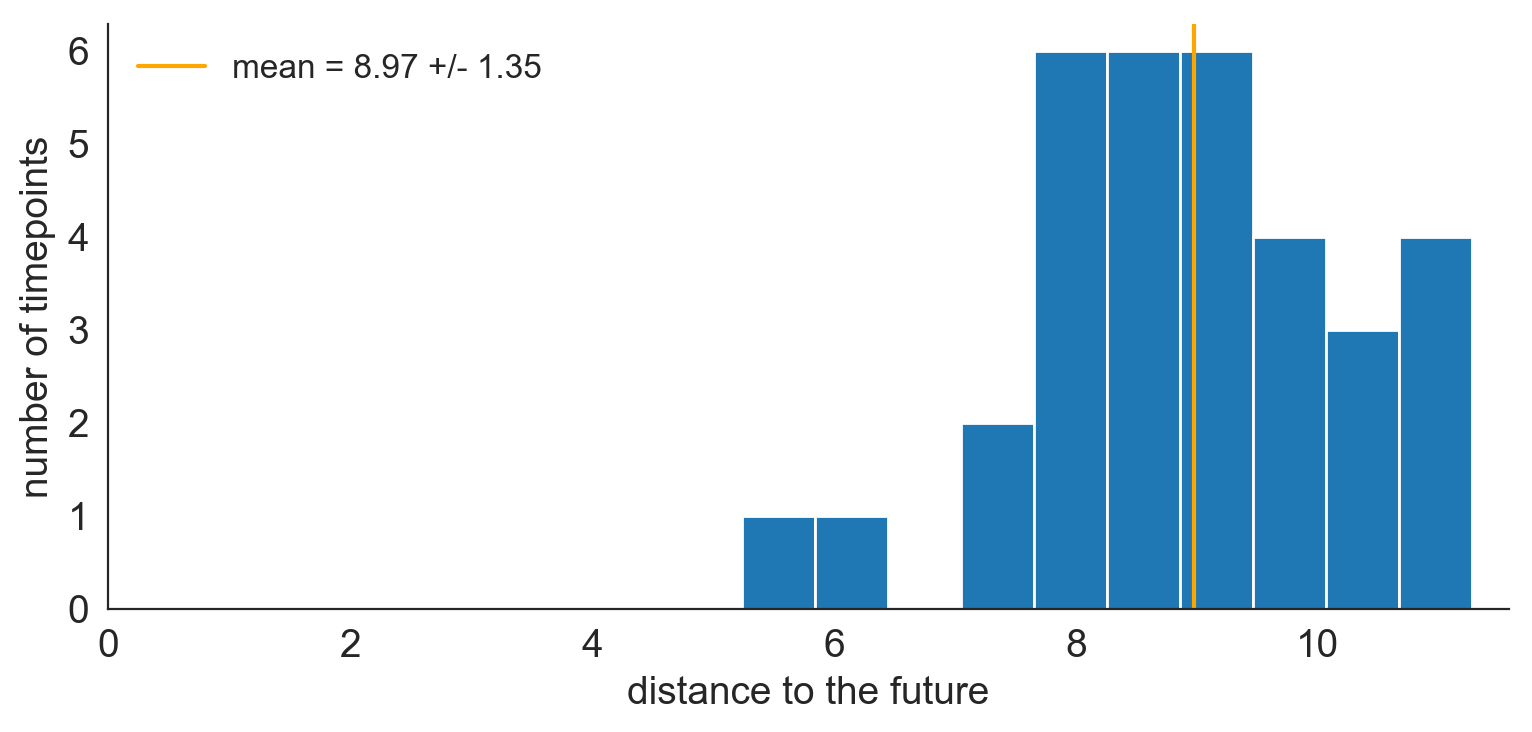

In [226]:
naive_simulated_errors_by_time_df = simulated_errors_by_time_df[simulated_errors_by_time_df["predictors"] == "naive"]["validation_error"]

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.hist(naive_simulated_errors_by_time_df, bins=10, label=None)
ax.set_xlabel("distance to the future")
ax.set_ylabel("number of timepoints")

mean_y = naive_simulated_errors_by_time_df.mean()
std_y = naive_simulated_errors_by_time_df.std()
ax.axvline(
    x=mean_y,
    color="orange",
    label="mean = %.2f +/- %.2f" % (mean_y, std_y)
)
ax.legend(
    frameon=False
)
ax.set_xlim(left=0)

plt.tight_layout()
plt.savefig("../manuscript/figures/distance-of-simulated-populations-between-timepoints.png")

### Natural populations

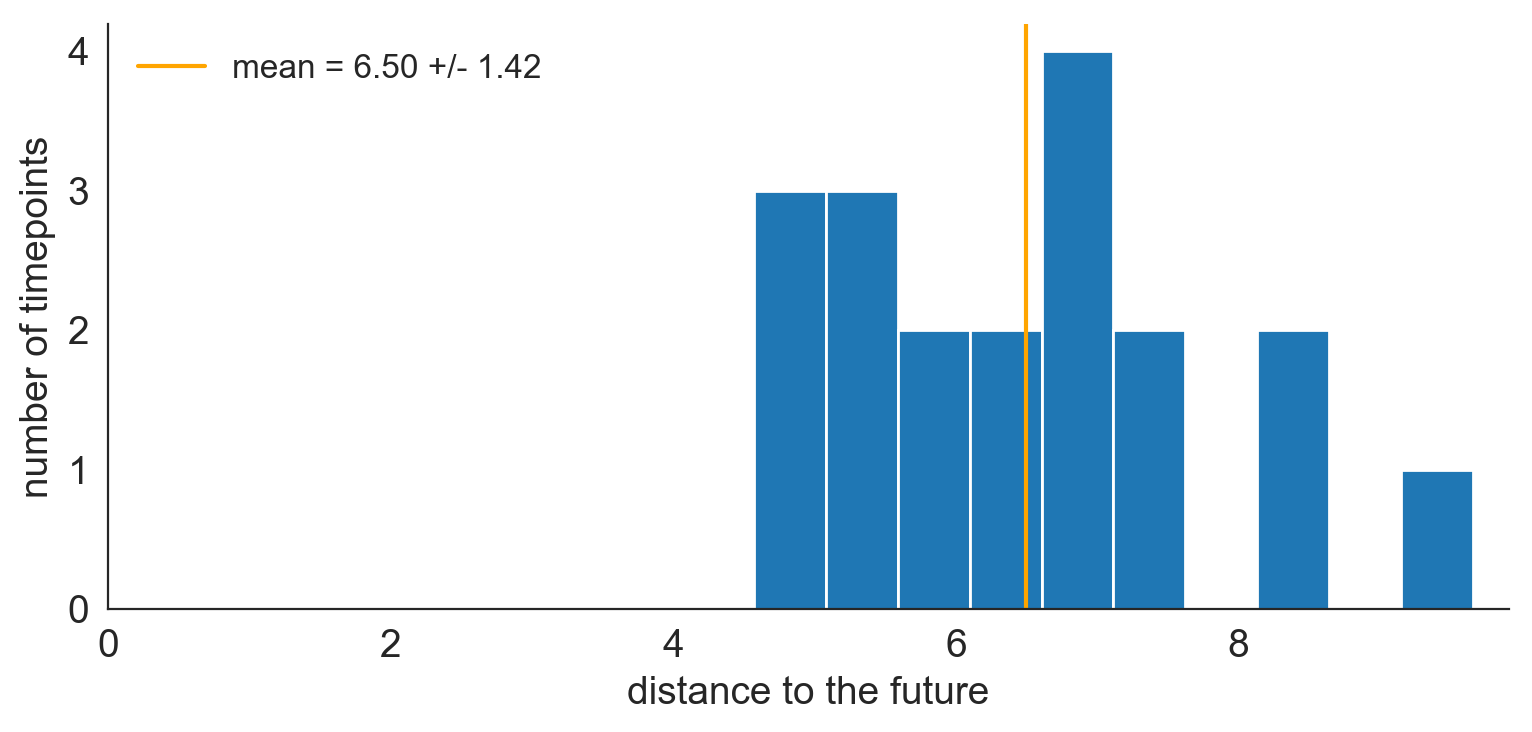

In [262]:
naive_natural_errors_by_time_df = natural_errors_by_time_df[natural_errors_by_time_df["predictors"] == "naive"]["validation_error"]

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.hist(naive_natural_errors_by_time_df, bins=10, label=None)
ax.set_xlabel("distance to the future")
ax.set_ylabel("number of timepoints")

mean_y = naive_natural_errors_by_time_df.mean()
std_y = naive_natural_errors_by_time_df.std()
ax.axvline(
    x=mean_y,
    color="orange",
    label="mean = %.2f +/- %.2f" % (mean_y, std_y)
)
ax.legend(
    frameon=False
)
ax.set_xlim(left=0)

plt.tight_layout()
plt.savefig("../manuscript/figures/distance-of-natural-populations-between-timepoints.png")

### Luksza and Lassig populations

In [ ]:
naive_luksza_errors_by_time_df = luksza_errors_by_time_df[luksza_errors_by_time_df["predictors"] == "naive"]["validation_error"]

fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.hist(naive_luksza_errors_by_time_df, bins=10)
ax.set_xlabel("distance to the future")
ax.set_ylabel("number of timepoints")

mean_y = naive_luksza_errors_by_time_df.mean()
std_y = naive_luksza_errors_by_time_df.std()
ax.axvline(
    x=mean_y,
    color="orange"
)

ax.text(
    0.5,
    0.8,
    "mean = %.2f +/- %.2f" % (mean_y, std_y),
    transform=ax.transAxes,
    fontsize=12,
    horizontalalignment="left"
)

plt.tight_layout()
plt.savefig("../manuscript/figures/distance-of-luksza-lassig-populations-between-timepoints.png")

## Figure 2: Summary of models for simulated populations

In [342]:
simulated_errors_by_time_df["model"] = simulated_errors_by_time_df["predictors"].apply(
    lambda predictor: " + ".join([name_by_predictor.get(predictor_name, predictor_name) for predictor_name in predictor.split("-")])
)

In [343]:
naive_simulated_errors_by_time_df = simulated_errors_by_time_df.query("predictors == 'naive'").copy()

In [344]:
naive_simulated_errors_by_time_df.head()

predictors  validation_error  validation_n validation_timepoint       type  \
0      naive          8.870808           630           2023-10-01  simulated   
1      naive          8.351673           630           2024-04-01  simulated   
2      naive         10.027961           630           2024-10-01  simulated   
3      naive         11.031343           630           2025-04-01  simulated   
4      naive          8.814196           630           2025-10-01  simulated   

               sample  model  
0  simulated_sample_3  naive  
1  simulated_sample_3  naive  
2  simulated_sample_3  naive  
3  simulated_sample_3  naive  
4  simulated_sample_3  naive

In [345]:
simulated_errors_by_time_df = simulated_errors_by_time_df.merge(
    naive_simulated_errors_by_time_df,
    on=["sample", "type", "validation_timepoint", "validation_n"],
    suffixes=["", "_naive"]
)

In [346]:
simulated_errors_by_time_df.head()

predictors  validation_error  validation_n validation_timepoint  \
0               naive          8.870808           630           2023-10-01   
1  normalized_fitness          7.427476           630           2023-10-01   
2                ep_x          8.893666           630           2023-10-01   
3             ne_star          7.452196           630           2023-10-01   
4                 lbi          9.502722           630           2023-10-01   

        type              sample                   model predictors_naive  \
0  simulated  simulated_sample_3                   naive            naive   
1  simulated  simulated_sample_3            true fitness            naive   
2  simulated  simulated_sample_3  epitope cross-immunity            naive   
3  simulated  simulated_sample_3   non-epitope mutations            naive   
4  simulated  simulated_sample_3                     LBI            naive   

   validation_error_naive model_naive  
0                8.870808       naive  
1                8.870808       naive  
2                8.870808       naive  
3                8.870808       naive  
4                8.870808       naive

In [347]:
simulated_errors_by_time_df["model_minus_naive"] = (
    simulated_errors_by_time_df["validation_error"] - simulated_errors_by_time_df["validation_error_naive"]
)

simulated_errors_by_time_df["model_better_than_naive"] = (simulated_errors_by_time_df["model_minus_naive"] < 0)

simulated_errors_by_time_df["relative_improvement"] = (
    simulated_errors_by_time_df["validation_error"] / simulated_errors_by_time_df["validation_error_naive"]
) - 1.0

In [348]:
simulated_errors_by_time_df.head()

predictors  validation_error  validation_n validation_timepoint  \
0               naive          8.870808           630           2023-10-01   
1  normalized_fitness          7.427476           630           2023-10-01   
2                ep_x          8.893666           630           2023-10-01   
3             ne_star          7.452196           630           2023-10-01   
4                 lbi          9.502722           630           2023-10-01   

        type              sample                   model predictors_naive  \
0  simulated  simulated_sample_3                   naive            naive   
1  simulated  simulated_sample_3            true fitness            naive   
2  simulated  simulated_sample_3  epitope cross-immunity            naive   
3  simulated  simulated_sample_3   non-epitope mutations            naive   
4  simulated  simulated_sample_3                     LBI            naive   

   validation_error_naive model_naive  model_minus_naive  \
0                8.870808       naive           0.000000   
1                8.870808       naive          -1.443331   
2                8.870808       naive           0.022859   
3                8.870808       naive          -1.418612   
4                8.870808       naive           0.631914   

   model_better_than_naive  relative_improvement  
0                    False              0.000000  
1                     True             -0.162706  
2                    False              0.002577  
3                     True             -0.159919  
4                    False              0.071235

In [349]:
simulated_model_selection = simulated_errors_by_time_df.groupby("model").aggregate({
    "model_minus_naive": ["mean", "std"],
    "model_better_than_naive": ["sum", "mean"]
}).sort_values(("model_minus_naive", "mean"))

simulated_model_selection.loc[:, ("model_better_than_naive", "sum")] = simulated_model_selection[("model_better_than_naive", "sum")].astype(int)

In [350]:
simulated_model_selection

model_minus_naive            \
                                         mean       std   
model                                                     
true fitness                        -2.166182  1.175078   
LBI + non-epitope mutations         -1.762497  1.009932   
LBI                                 -1.411100  1.304335   
delta frequency                     -0.851867  0.925450   
non-epitope mutations               -0.713624  0.566839   
naive                                0.000000  0.000000   
epitope cross-immunity               0.031517  0.221122   

                            model_better_than_naive            
                                                sum      mean  
model                                                          
true fitness                                     32  0.969697  
LBI + non-epitope mutations                      32  0.969697  
LBI                                              29  0.878788  
delta frequency                                  26  0.787879  
non-epitope mutations                            29  0.878788  
naive                                             0  0.000000  
epitope cross-immunity                           14  0.424242

In [240]:
simulated_model_selection_table = simulated_model_selection.to_latex(
    float_format="%.2f"
)

with open("../manuscript/tables/simulated_model_selection.tex", "w") as oh:
    oh.write(simulated_model_selection_table)

In [241]:
simulated_errors_by_time_df.head(1)

predictors  validation_error  validation_n validation_timepoint       type  \
0      naive          8.870808           630           2023-10-01  simulated   

               sample  model predictors_naive  validation_error_naive  \
0  simulated_sample_3  naive            naive                8.870808   

  model_naive  model_minus_naive  model_better_than_naive  \
0       naive                0.0                    False   

   relative_improvement  
0                   0.0

coefficient predictor predictors validation_timepoint       type  \
0          0.0     naive      naive           2023-10-01  simulated   
1          0.0     naive      naive           2024-04-01  simulated   
2          0.0     naive      naive           2024-10-01  simulated   
3          0.0     naive      naive           2025-04-01  simulated   
4          0.0     naive      naive           2025-10-01  simulated   

               sample  
0  simulated_sample_3  
1  simulated_sample_3  
2  simulated_sample_3  
3  simulated_sample_3  
4  simulated_sample_3

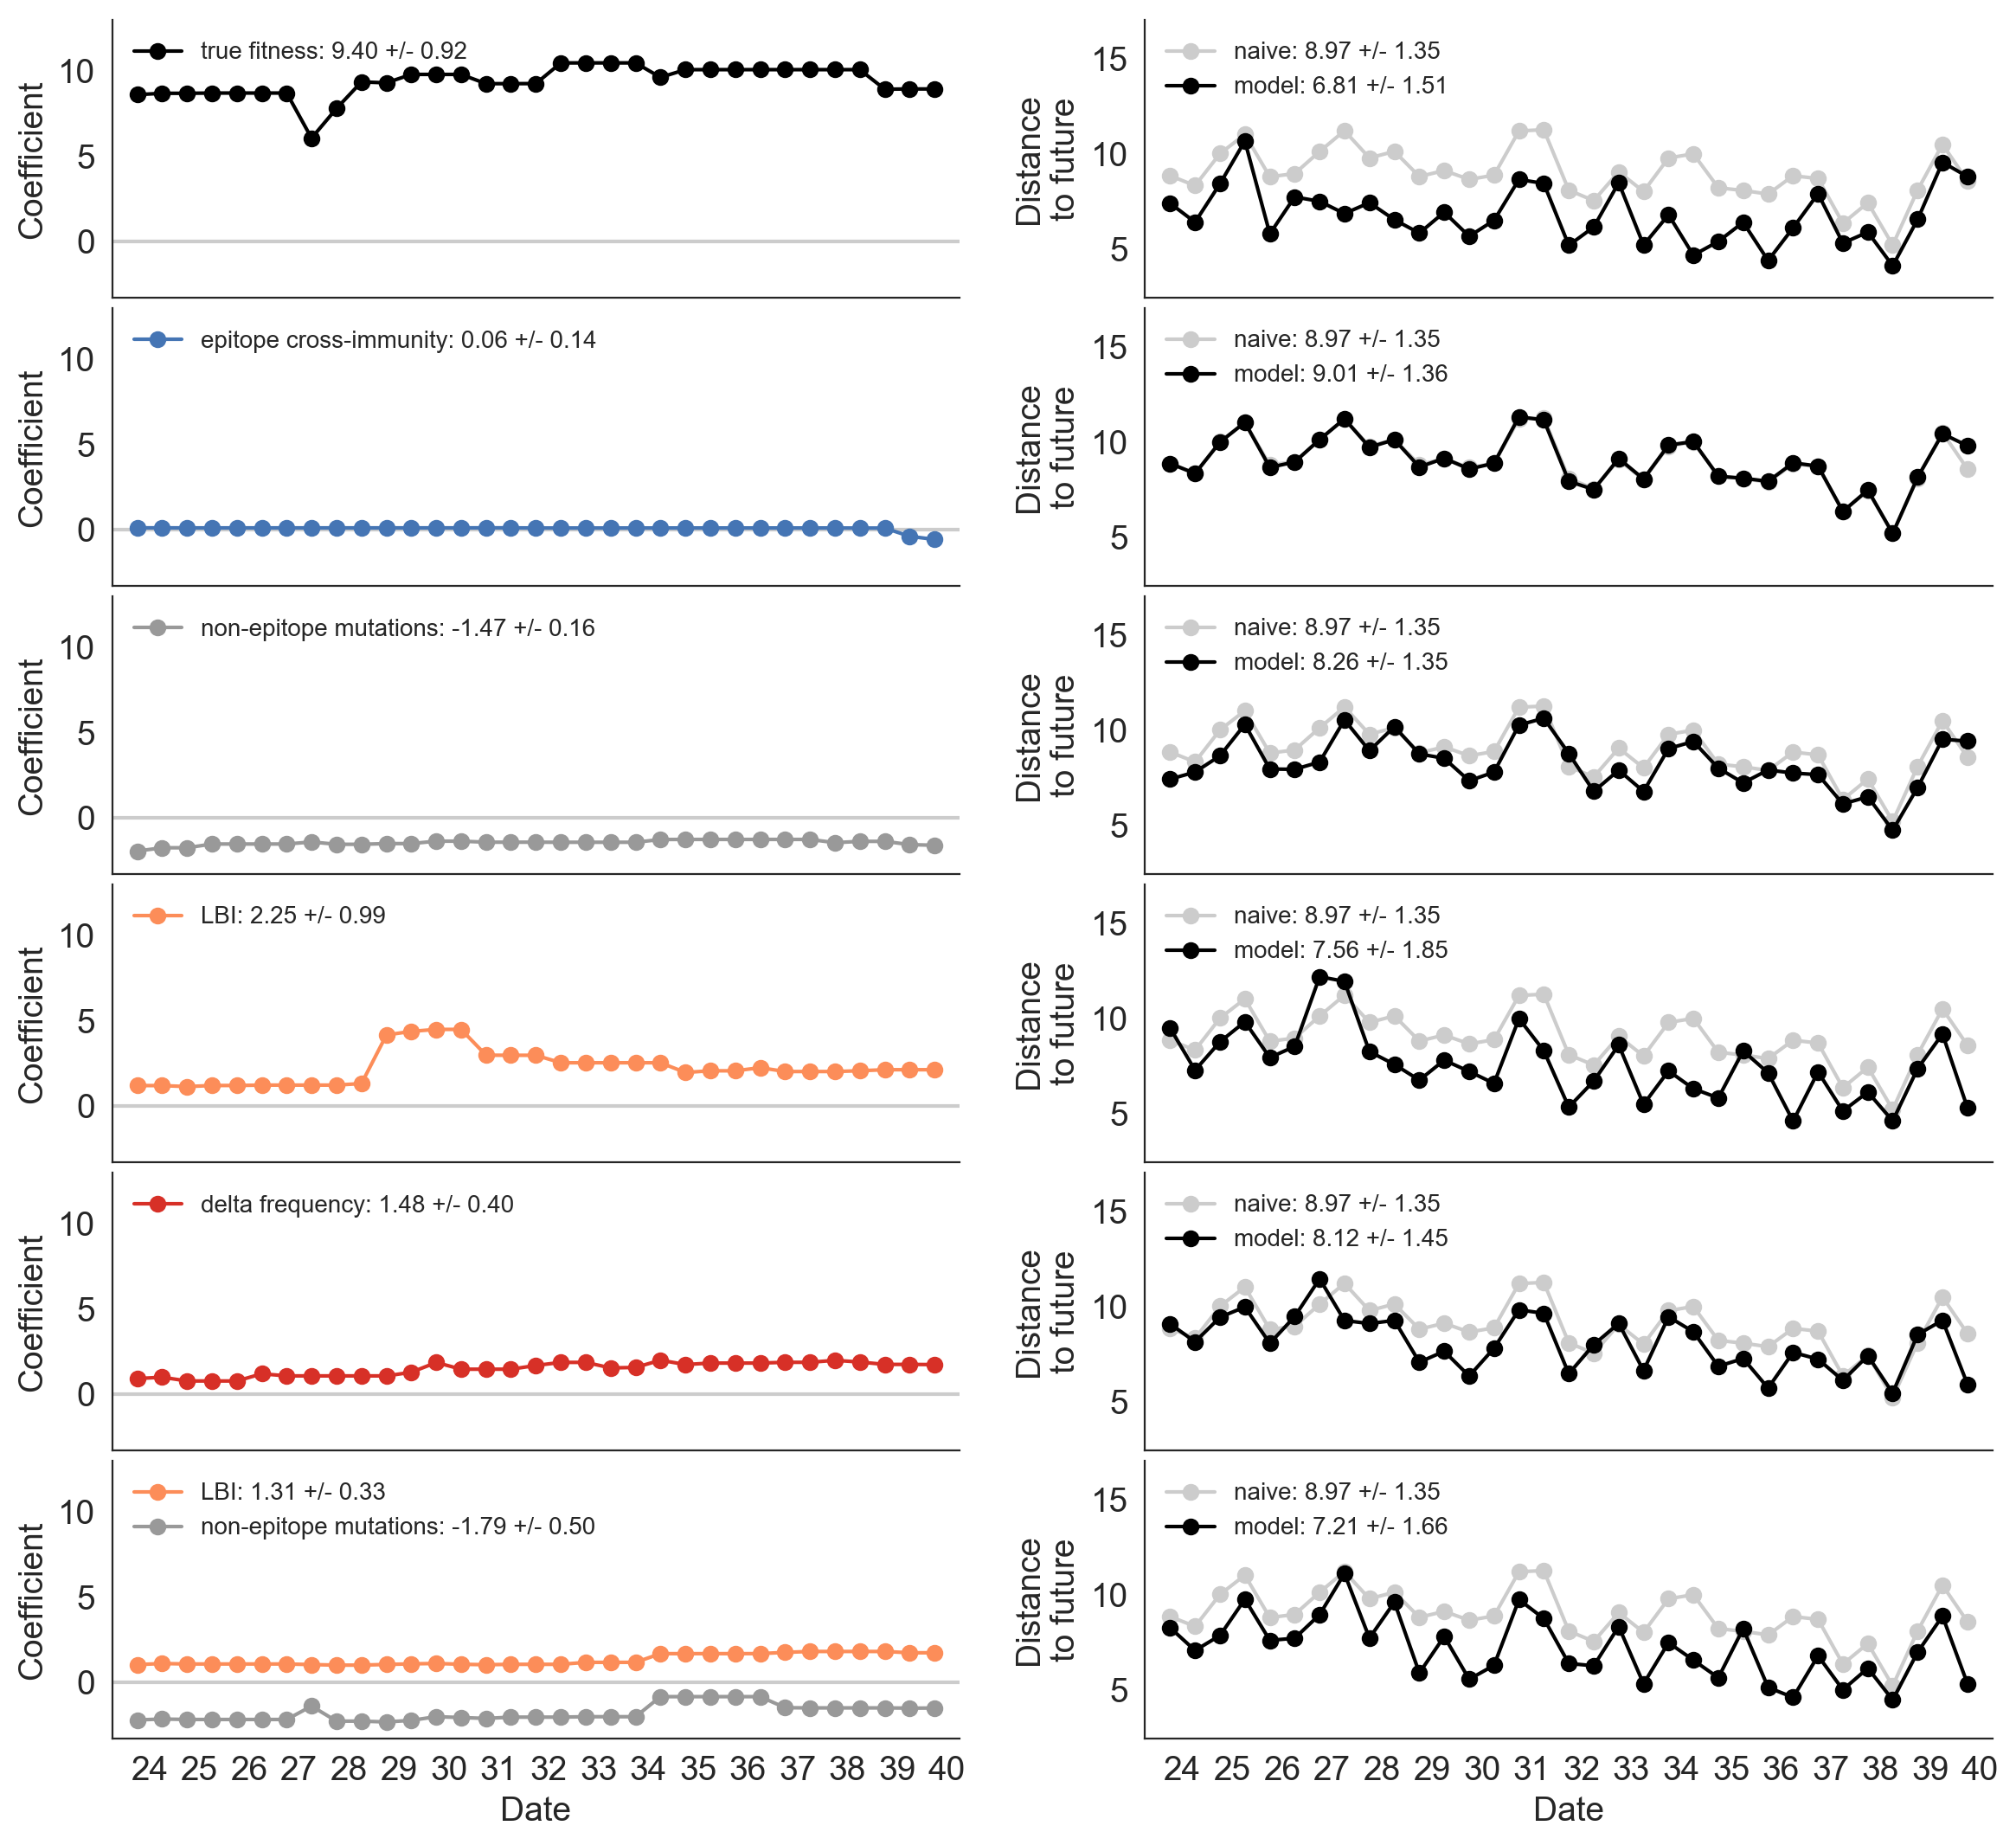

In [371]:
fig, axes, gs = plot_accuracy_and_coefficients_for_build(
    simulated_errors_by_time_df,
    simulated_coefficients_by_time_df,
    get_individual_predictors_for_data_frame(simulated_errors_by_time_df) + ["lbi-ne_star"],
    rotation=0,
    years_fmt_string="%y",
    date_fmt_string="%y-%m",
    height=11,
    hspace=0.1,
    share_y=True,
    max_coefficient=13,
    max_normal_error=17
)
#plt.savefig("../manuscript/figures/unadjusted-model-accuracy-and-coefficients-for-simulated-populations.png")

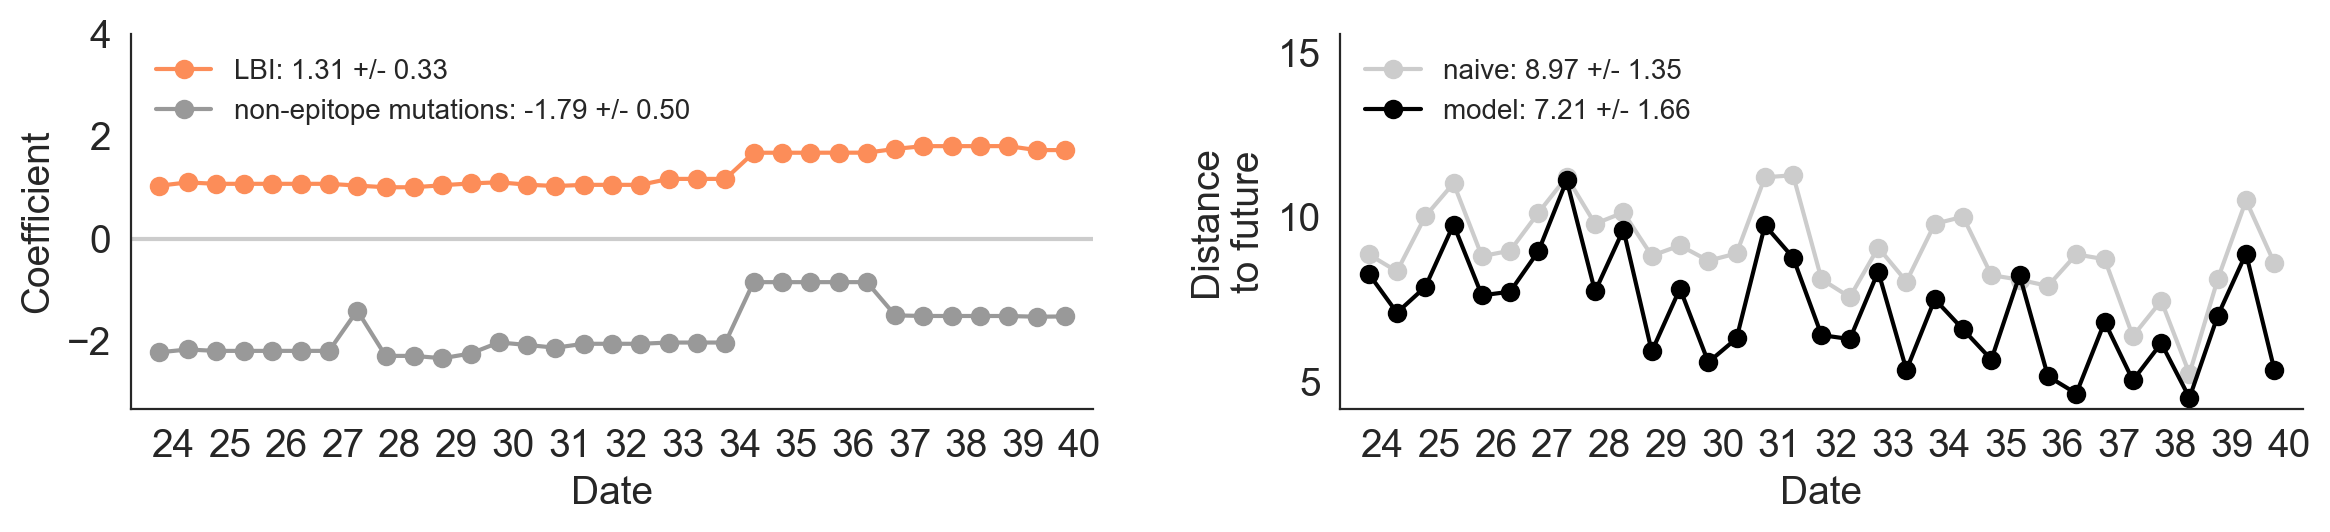

In [322]:
fig, axes, gs = plot_accuracy_and_coefficients_for_build(
    simulated_errors_by_time_df,
    simulated_coefficients_by_time_df,
    get_composite_predictors_for_data_frame(simulated_errors_by_time_df),
    rotation=0,
    years_fmt_string="%y",
    date_fmt_string="%y-%m",
    height=3,
    max_coefficient=4
)
plt.savefig("../manuscript/figures/unadjusted-composite-model-accuracy-and-coefficients-for-simulated-populations.png")

## Figure 3: Summary of models for natural populations

In [373]:
natural_errors_by_time_df["validation_timepoint"].unique().shape

(19,)

In [277]:
natural_errors_by_time_df["model"] = natural_errors_by_time_df["predictors"].apply(
    lambda predictor: " + ".join([name_by_predictor.get(predictor_name, predictor_name) for predictor_name in predictor.split("-")])
)

In [278]:
naive_natural_errors_by_time_df = natural_errors_by_time_df.query("predictors == 'naive'").copy()

In [279]:
natural_errors_by_time_df = natural_errors_by_time_df.merge(
    naive_natural_errors_by_time_df,
    on=["sample", "type", "validation_timepoint", "validation_n"],
    suffixes=["", "_naive"]
)

In [280]:
natural_errors_by_time_df.head()

predictors  validation_error  validation_n validation_timepoint     type  \
0      naive          5.809968           460           2005-10-01  natural   
1         ep          5.746956           460           2005-10-01  natural   
2    ep_wolf          5.770946           460           2005-10-01  natural   
3       ep_x          8.982179           460           2005-10-01  natural   
4         rb          5.819241           460           2005-10-01  natural   

                                 sample                   model  \
0  natural_sample_0_with_90_vpm_sliding                   naive   
1  natural_sample_0_with_90_vpm_sliding       epitope mutations   
2  natural_sample_0_with_90_vpm_sliding  Wolf epitope mutations   
3  natural_sample_0_with_90_vpm_sliding  epitope cross-immunity   
4  natural_sample_0_with_90_vpm_sliding  Koel epitope mutations   

  predictors_naive  validation_error_naive model_naive  
0            naive                5.809968       naive  
1            naive                5.809968       naive  
2            naive                5.809968       naive  
3            naive                5.809968       naive  
4            naive                5.809968       naive

In [281]:
natural_errors_by_time_df["model_minus_naive"] = (
    natural_errors_by_time_df["validation_error"] - natural_errors_by_time_df["validation_error_naive"]
)

natural_errors_by_time_df["model_better_than_naive"] = (natural_errors_by_time_df["model_minus_naive"] < 0)

natural_errors_by_time_df["relative_improvement"] = (
    natural_errors_by_time_df["validation_error"] / natural_errors_by_time_df["validation_error_naive"]
) - 1.0

In [282]:
natural_model_selection = natural_errors_by_time_df.groupby("model").aggregate({
    "model_minus_naive": ["mean"],
    "model_better_than_naive": ["sum", "mean"]
}).sort_values(("model_minus_naive", "mean"))

natural_model_selection.loc[:, ("model_better_than_naive", "sum")] = natural_model_selection[("model_better_than_naive", "sum")].astype(int)

In [283]:
natural_model_selection

model_minus_naive  \
                                                                mean   
model                                                                  
HI tree cross-immunity + non-epitope mutations ...         -1.205920   
non-epitope mutations + LBI                                -1.140519   
LBI                                                        -0.781969   
HI tree cross-immunity + non-epitope mutations             -0.668082   
HI tree cross-immunity                                     -0.412502   
non-epitope mutations                                      -0.397921   
HI tree                                                    -0.339891   
delta frequency                                            -0.213213   
DMS mutation effect                                        -0.187890   
Koel epitope mutations                                     -0.146577   
DMS entropy                                                -0.032939   
naive                                                       0.000000   
DMS non-epitope                                             0.000516   
HI sub cross-immunity                                       0.060066   
linear HI mut phenotypes                                    0.249120   
Wolf epitope mutations                                      0.315972   
epitope mutations                                           0.637940   
epitope cross-immunity                                      0.812467   

                                                   model_better_than_naive  \
                                                                       sum   
model                                                                        
HI tree cross-immunity + non-epitope mutations ...                      15   
non-epitope mutations + LBI                                             15   
LBI                                                                     12   
HI tree cross-immunity + non-epitope mutations                          14   
HI tree cross-immunity                                                  15   
non-epitope mutations                                                   14   
HI tree                                                                 12   
delta frequency                                                         12   
DMS mutation effect                                                     11   
Koel epitope mutations                                                  12   
DMS entropy                                                             13   
naive                                                                    0   
DMS non-epitope                                                         11   
HI sub cross-immunity                                                    9   
linear HI mut phenotypes                                                 9   
Wolf epitope mutations                                                   6   
epitope mutations                                                        3   
epitope cross-immunity                                                   1   

                                                              
                                                        mean  
model                                                         
HI tree cross-immunity + non-epitope mutations ...  0.789474  
non-epitope mutations + LBI                         0.789474  
LBI                                                 0.631579  
HI tree cross-immunity + non-epitope mutations      0.736842  
HI tree cross-immunity                              0.789474  
non-epitope mutations                               0.736842  
HI tree                                             0.631579  
delta frequency                                     0.631579  
DMS mutation effect                                 0.578947  
Koel epitope mutations                              0.631579  
DMS entropy                                         0.684211  
naive            

In [284]:
natural_model_selection_table = natural_model_selection.to_latex(
    float_format="%.2f"
)

with open("../manuscript/tables/natural_model_selection.tex", "w") as oh:
    oh.write(natural_model_selection_table)

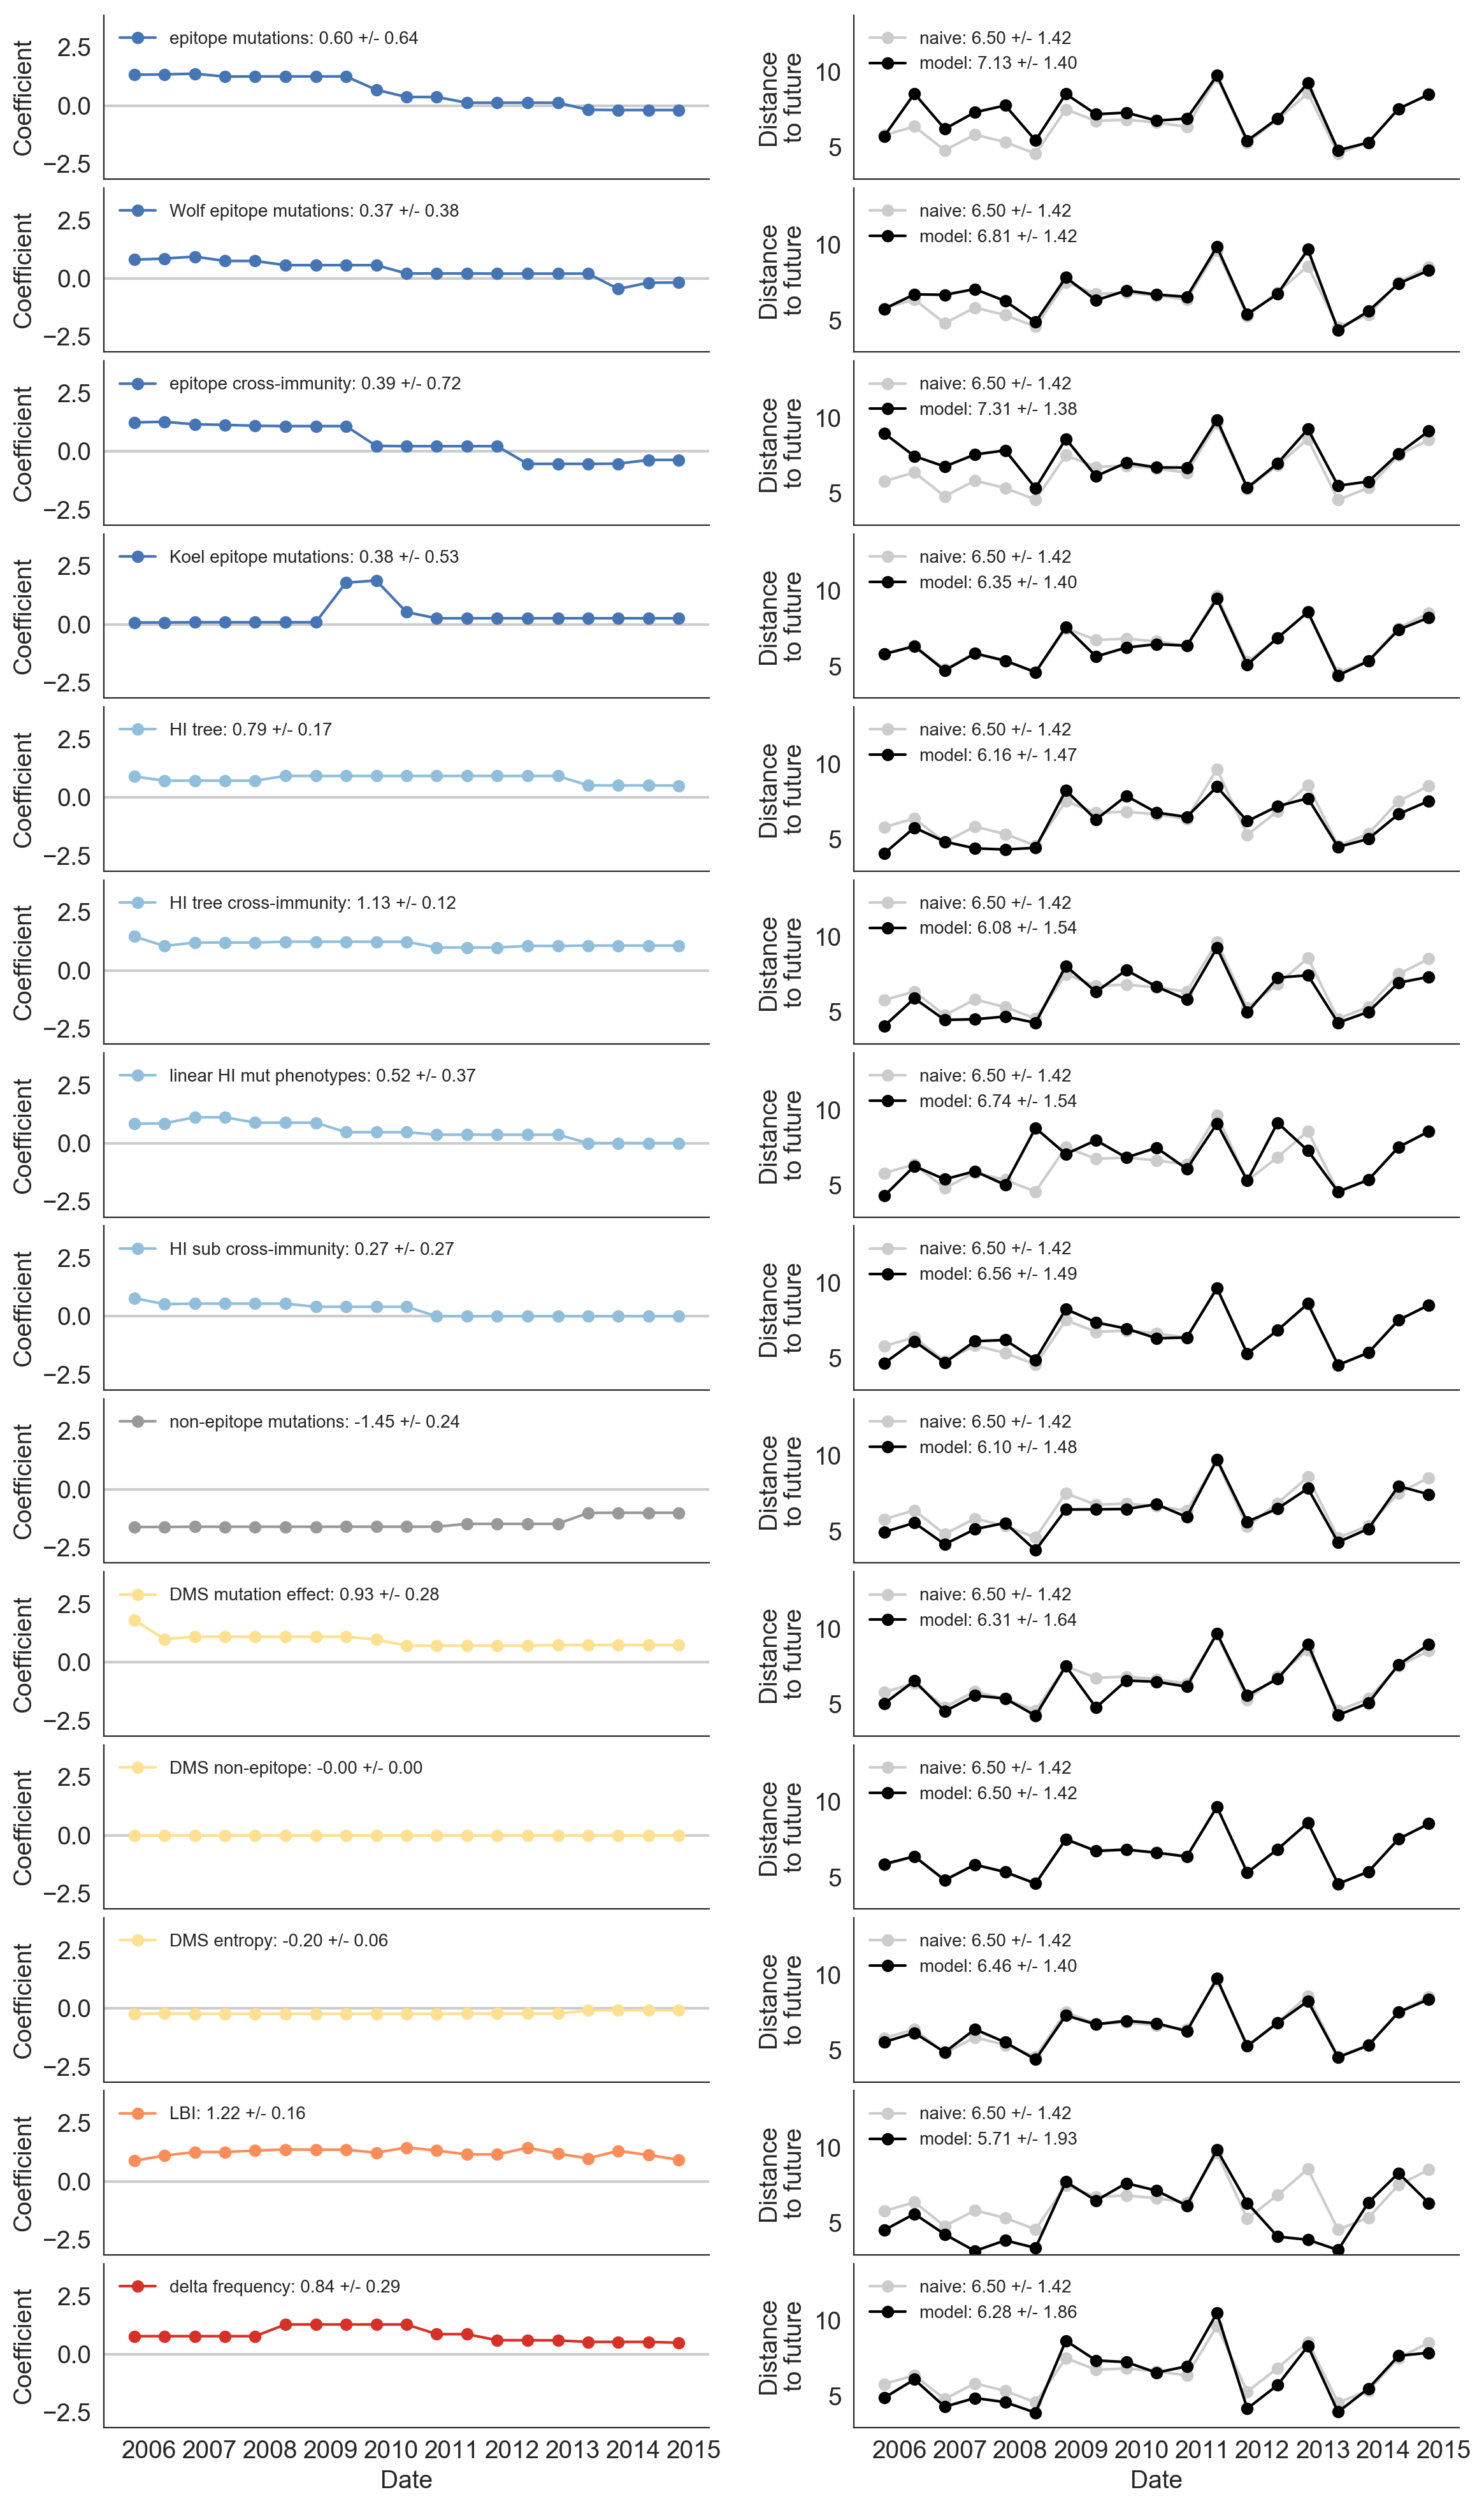

In [339]:
fig, axes, gs = plot_accuracy_and_coefficients_for_build(
    natural_errors_by_time_df,
    natural_coefficients_by_time_df,
    get_individual_predictors_for_data_frame(natural_errors_by_time_df),
    height=20,
    rotation=0
)
plt.savefig("../manuscript/figures/unadjusted-model-accuracy-and-coefficients-for-natural-populations-all-individual-predictors.png")

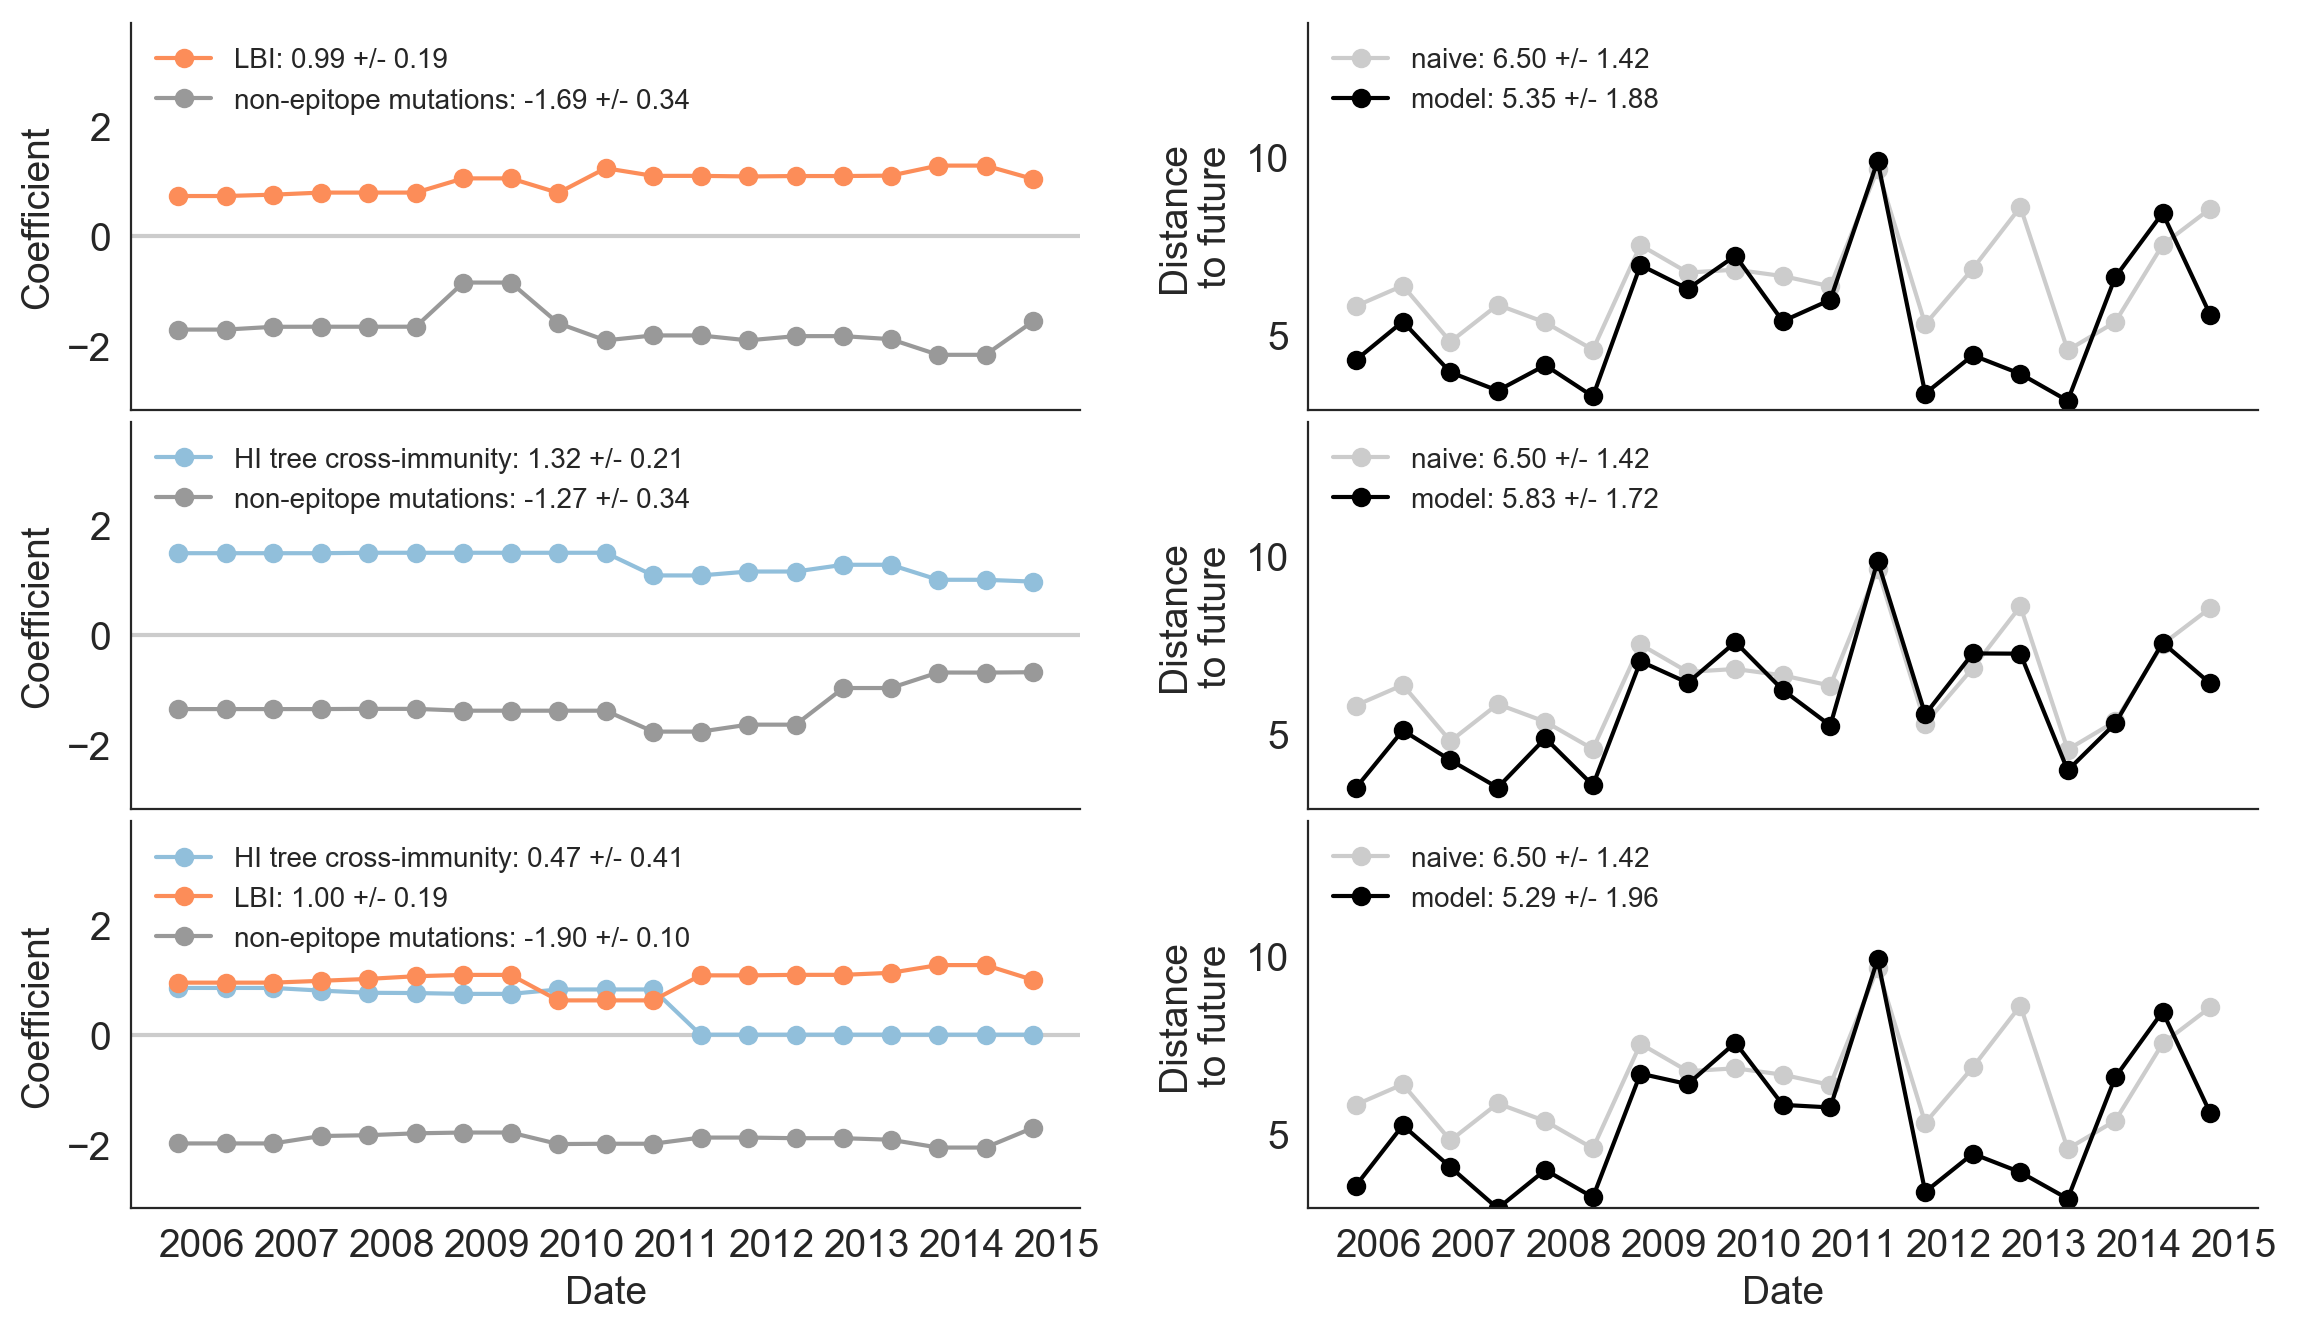

In [338]:
fig, axes, gs = plot_accuracy_and_coefficients_for_build(
    natural_errors_by_time_df,
    natural_coefficients_by_time_df,
    get_composite_predictors_for_data_frame(natural_errors_by_time_df),
    height=7,
    rotation=0
)
#plt.savefig("../manuscript/figures/unadjusted-composite-model-accuracy-and-coefficients-for-natural-populations-all-composite-predictors.png")

### Individual models

In [308]:
subset_of_individual_predictors = [
    "ep_x",
    "cTiter_x",
    "ne_star",
    "dms_star",
    "lbi",
    "delta_frequency"
]

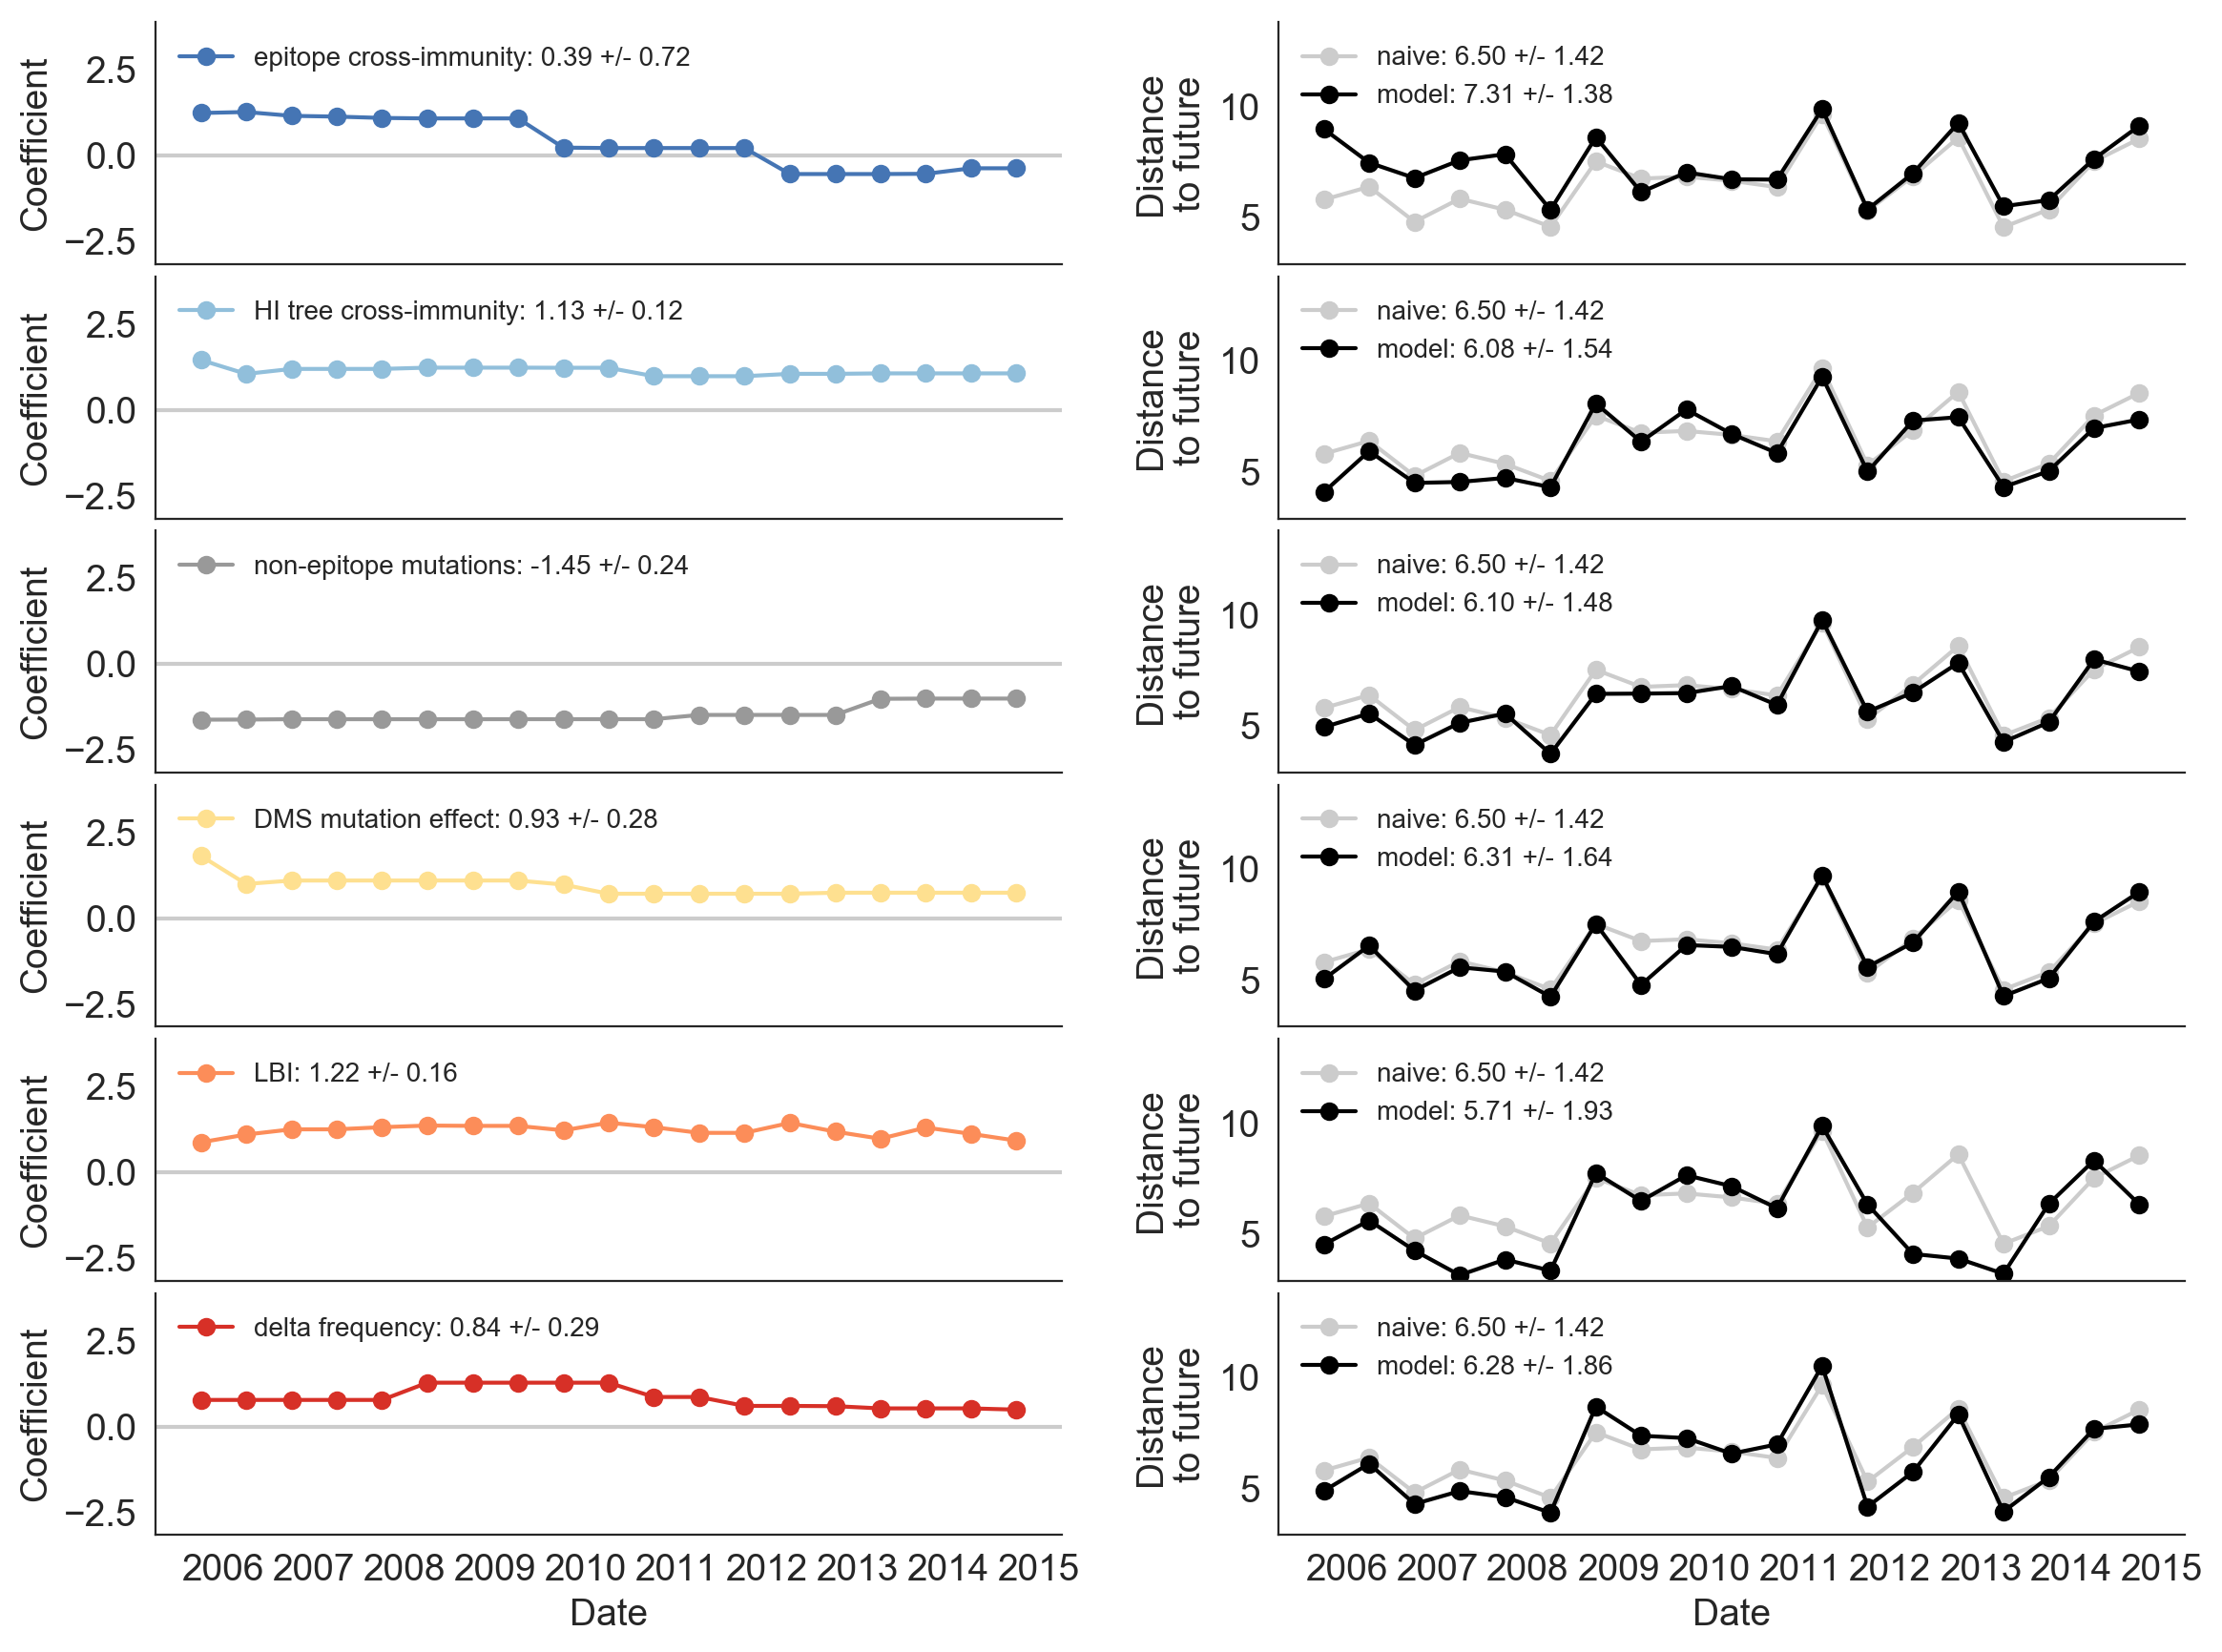

In [340]:
fig, axes, gs = plot_accuracy_and_coefficients_for_build(
    natural_errors_by_time_df,
    natural_coefficients_by_time_df,
    subset_of_individual_predictors,
    height=9,
    rotation=0
)
plt.savefig("../manuscript/figures/unadjusted-model-accuracy-and-coefficients-for-natural-populations.png")

### Within category model comparisons

#### Antigenic

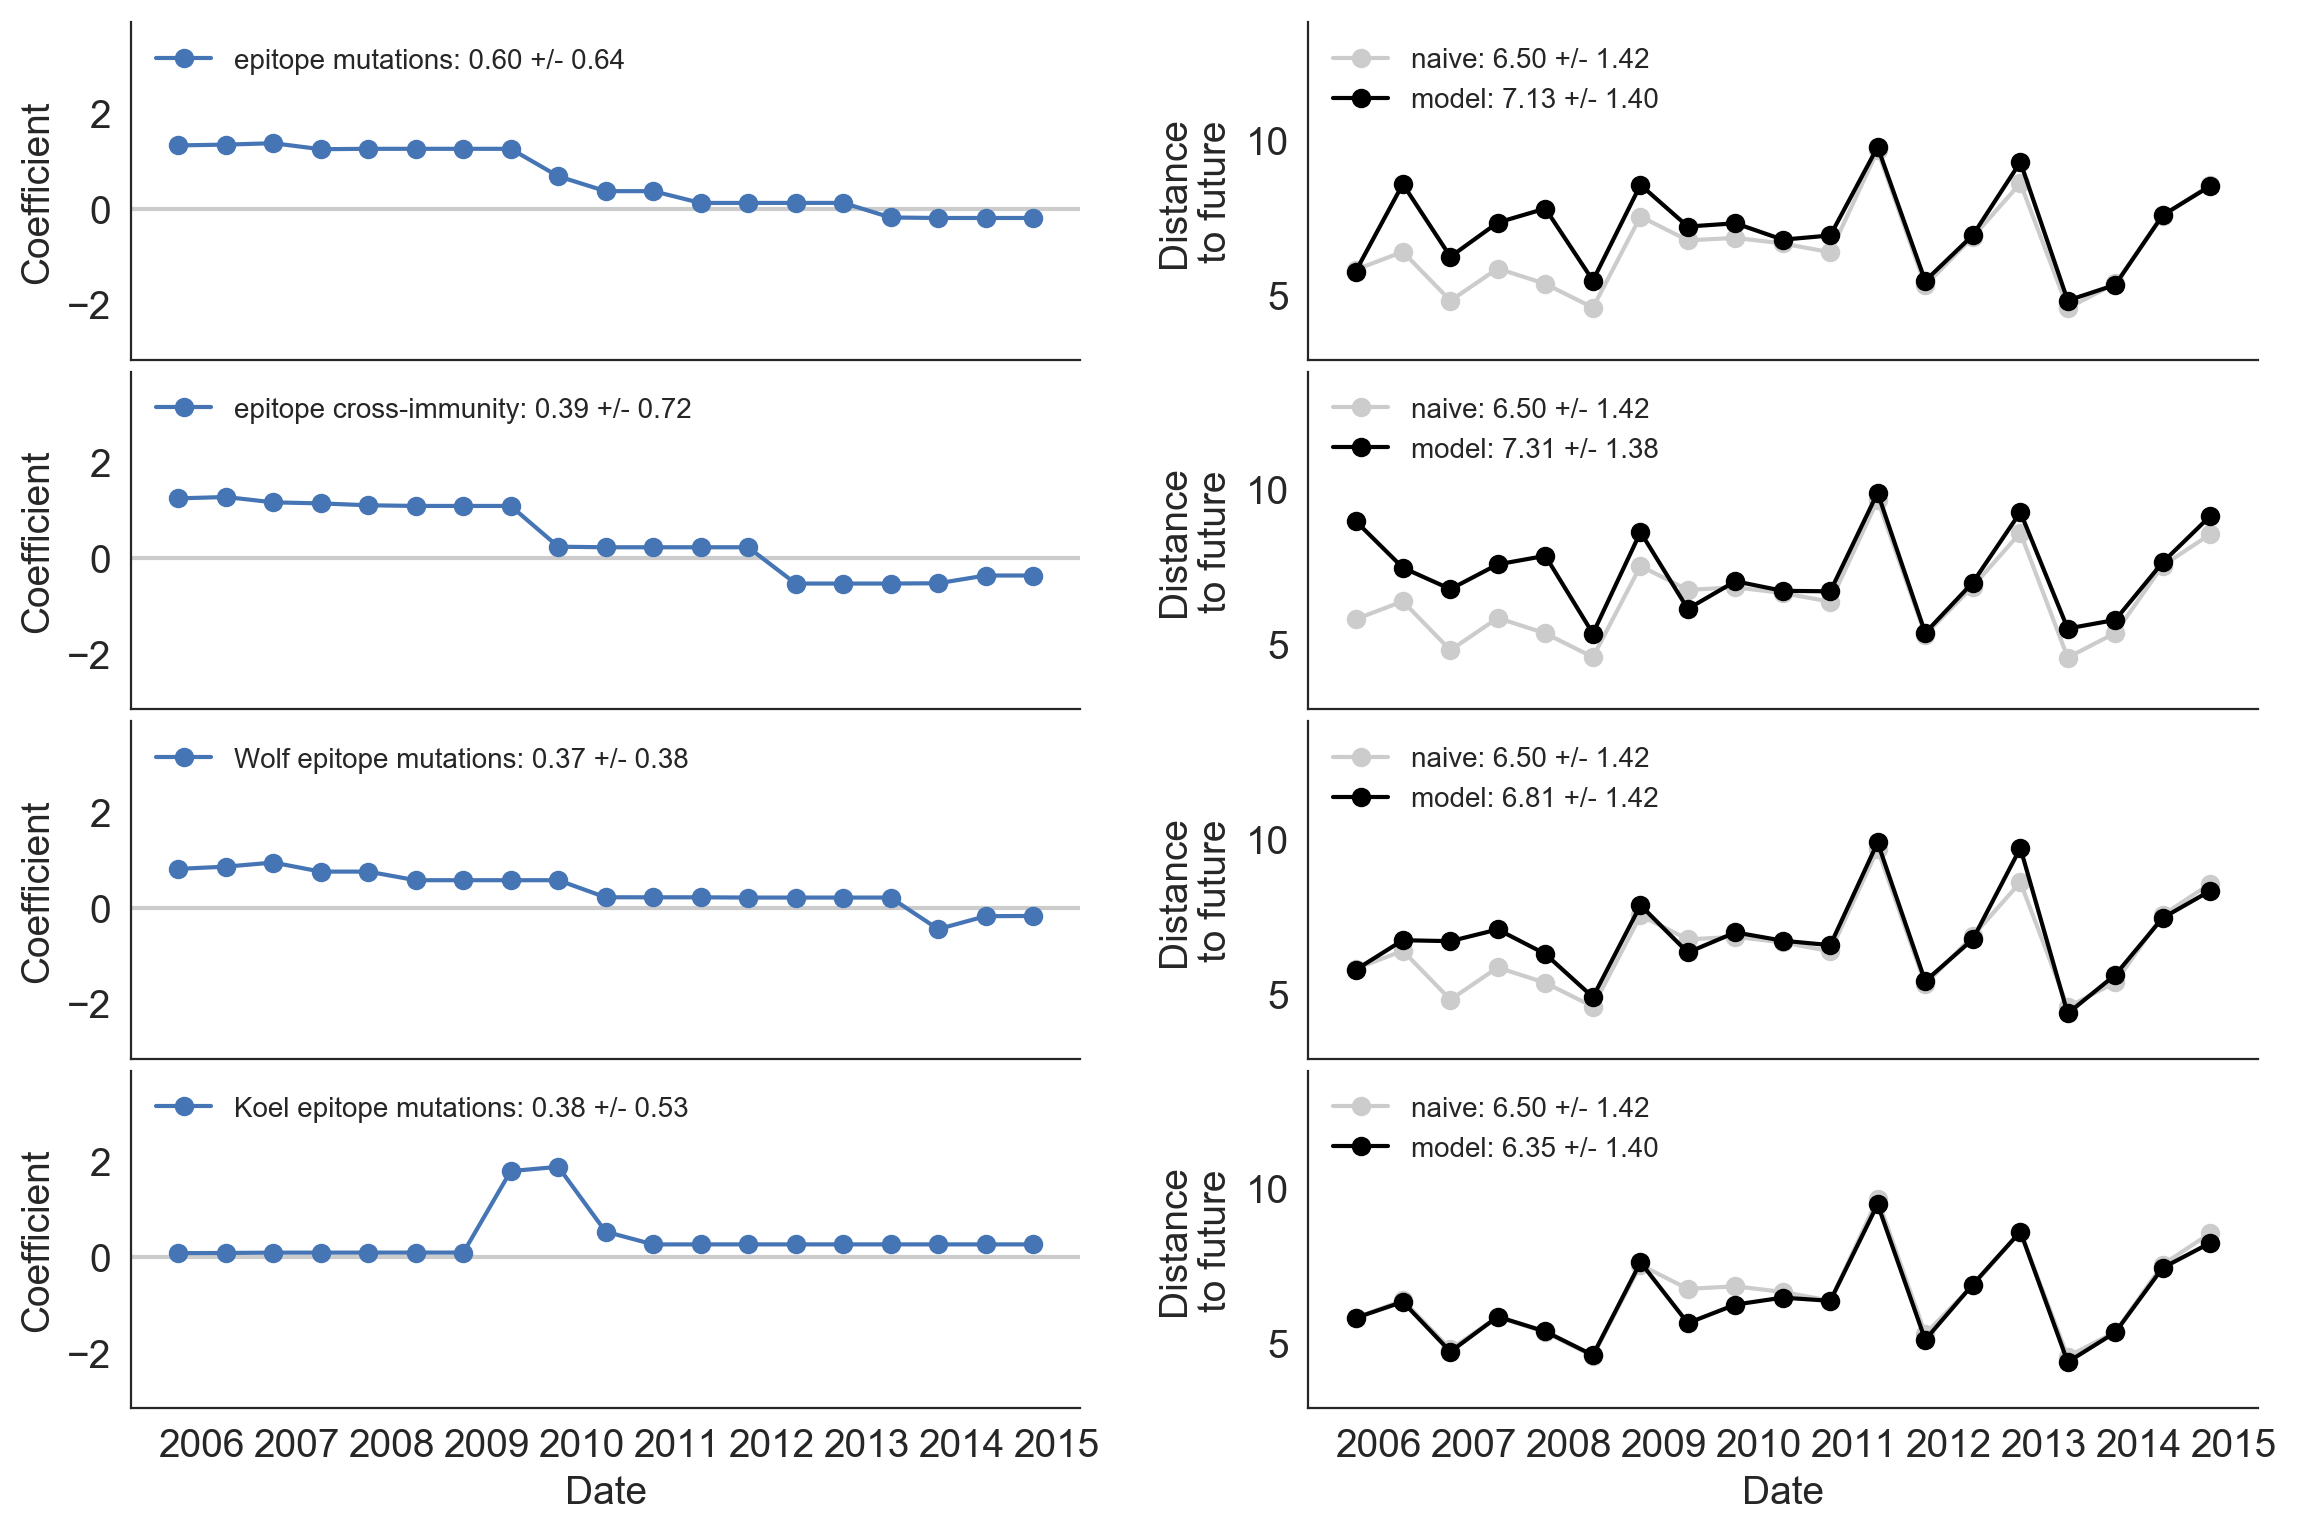

In [337]:
fig, axes, gs = plot_accuracy_and_coefficients_for_build(
    natural_errors_by_time_df,
    natural_coefficients_by_time_df,
    ["ep", "ep_x", "ep_wolf", "rb"],
    height=8,
    rotation=0
)
plt.savefig("../manuscript/figures/unadjusted-epitope-model-accuracy-and-coefficients-for-natural-populations.png")

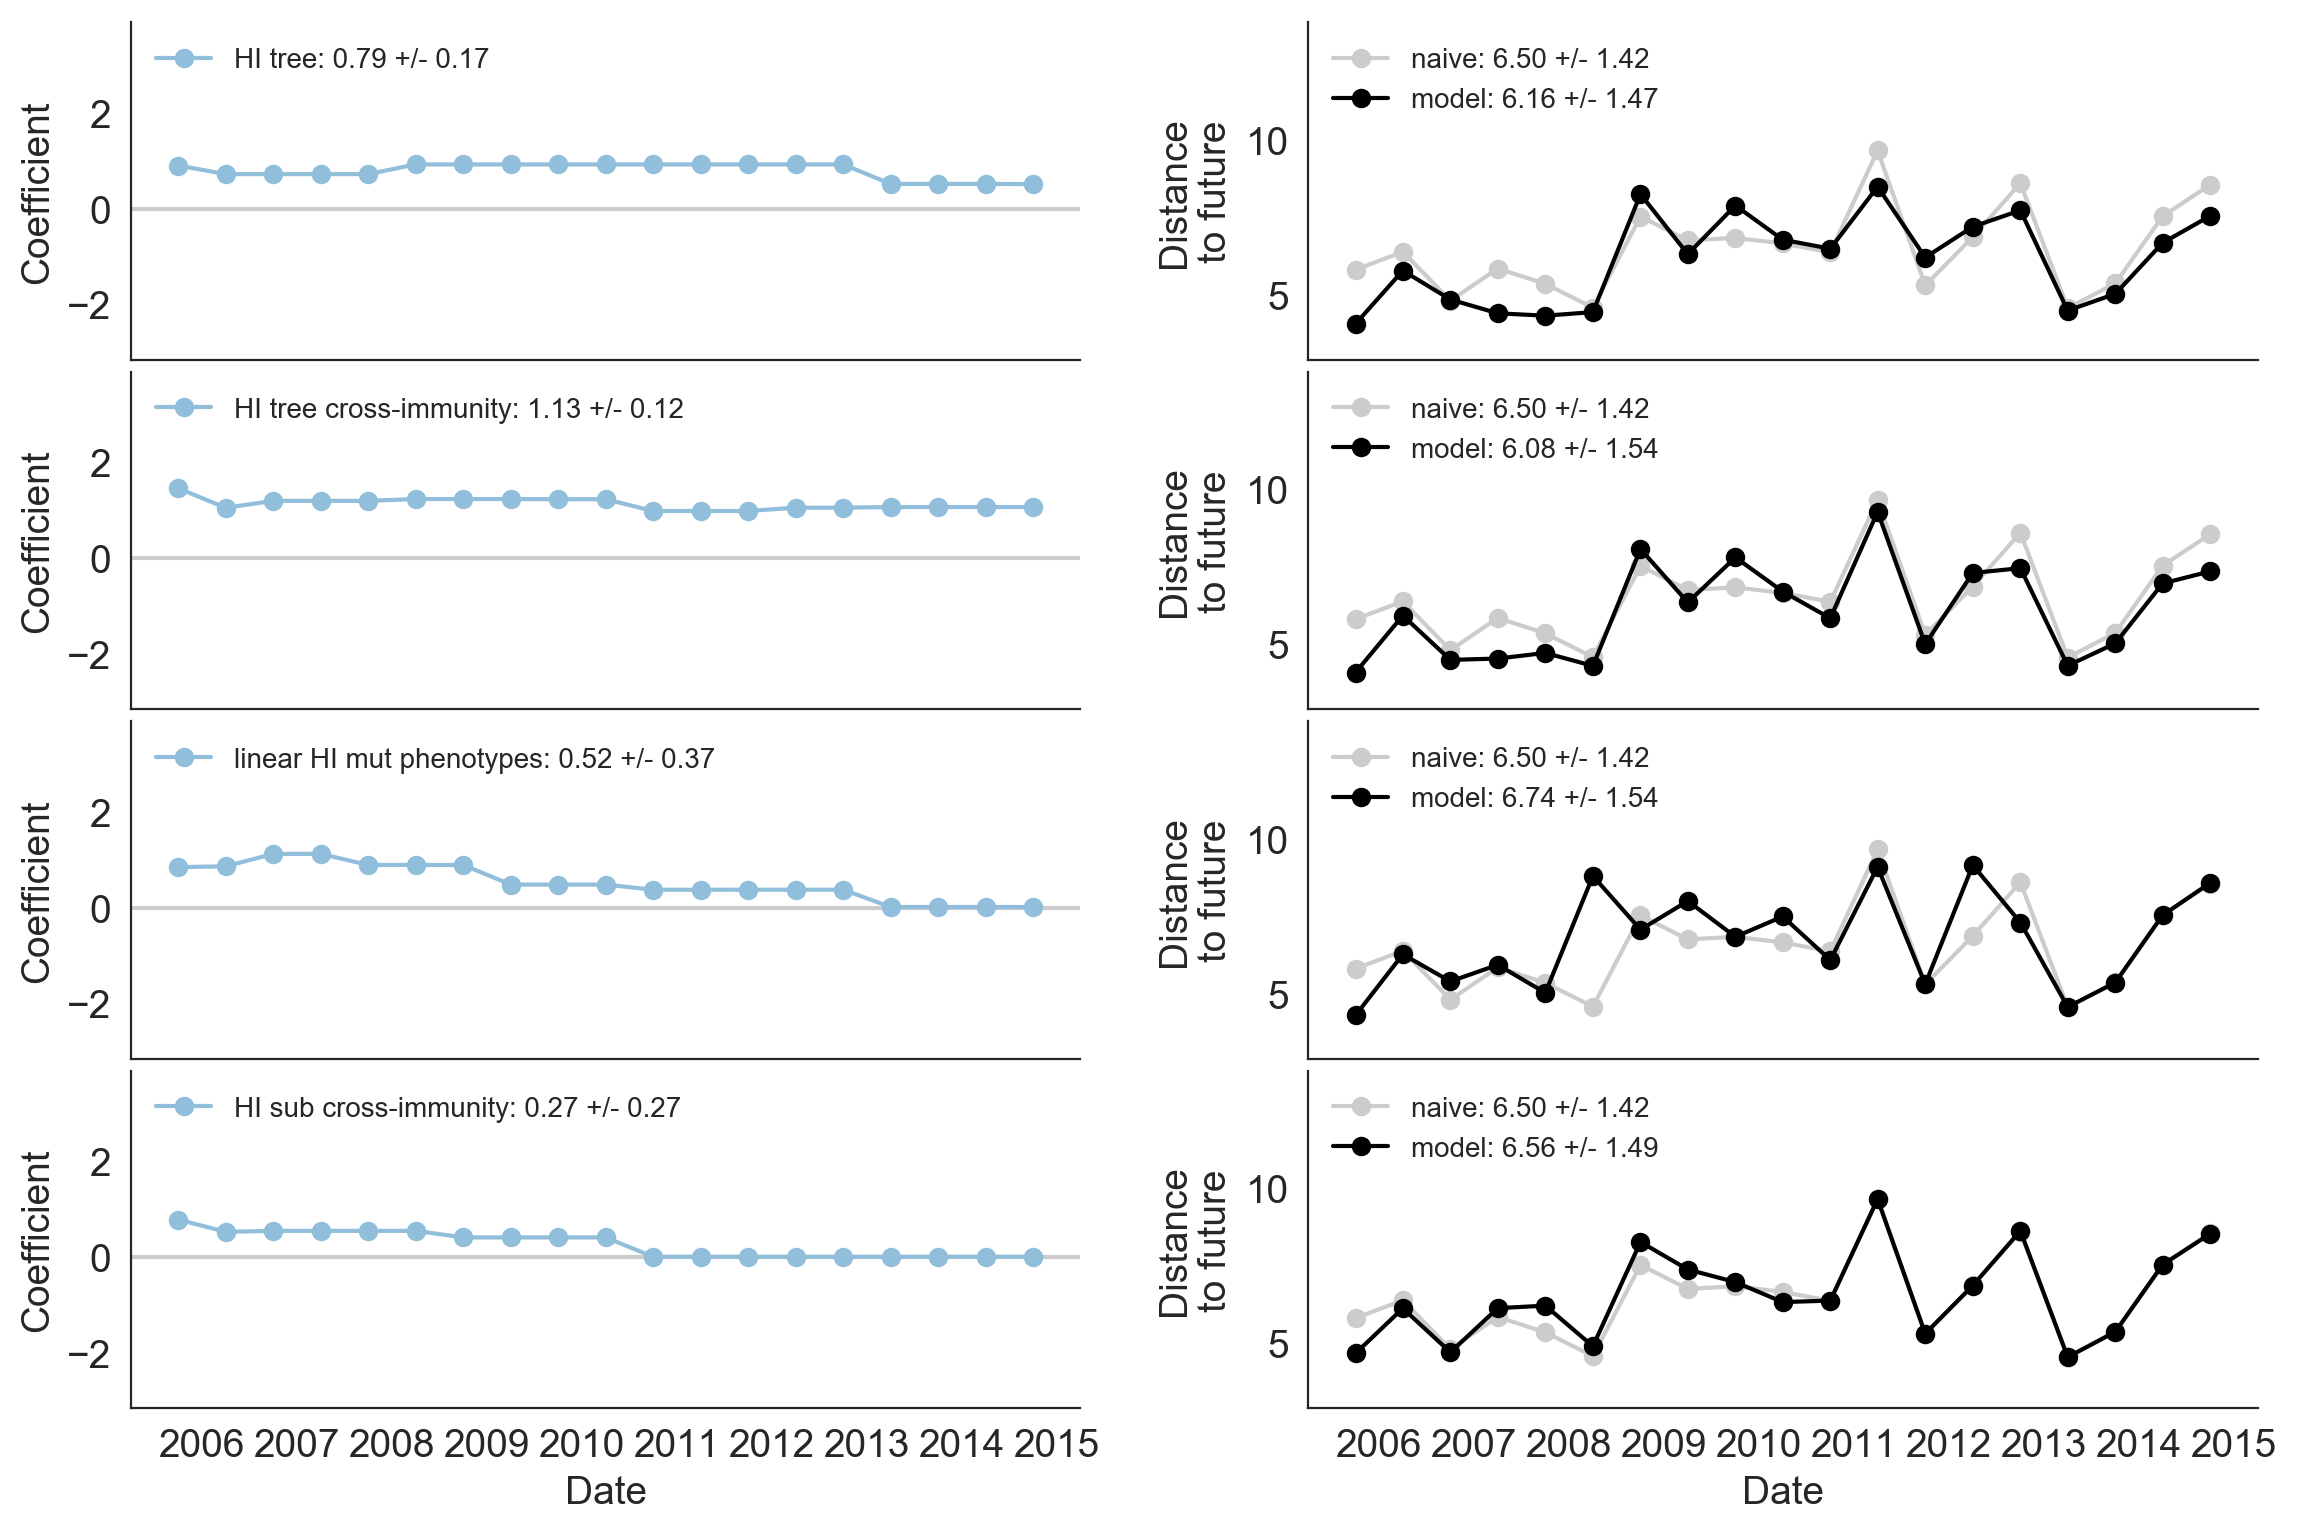

In [336]:
fig, axes, gs = plot_accuracy_and_coefficients_for_build(
    natural_errors_by_time_df,
    natural_coefficients_by_time_df,
    ["cTiter", "cTiter_x", "cTiterSub", "cTiterSub_x"],
    height=8,
    rotation=0
)
plt.savefig("../manuscript/figures/unadjusted-HI-model-accuracy-and-coefficients-for-natural-populations.png")

#### Functional

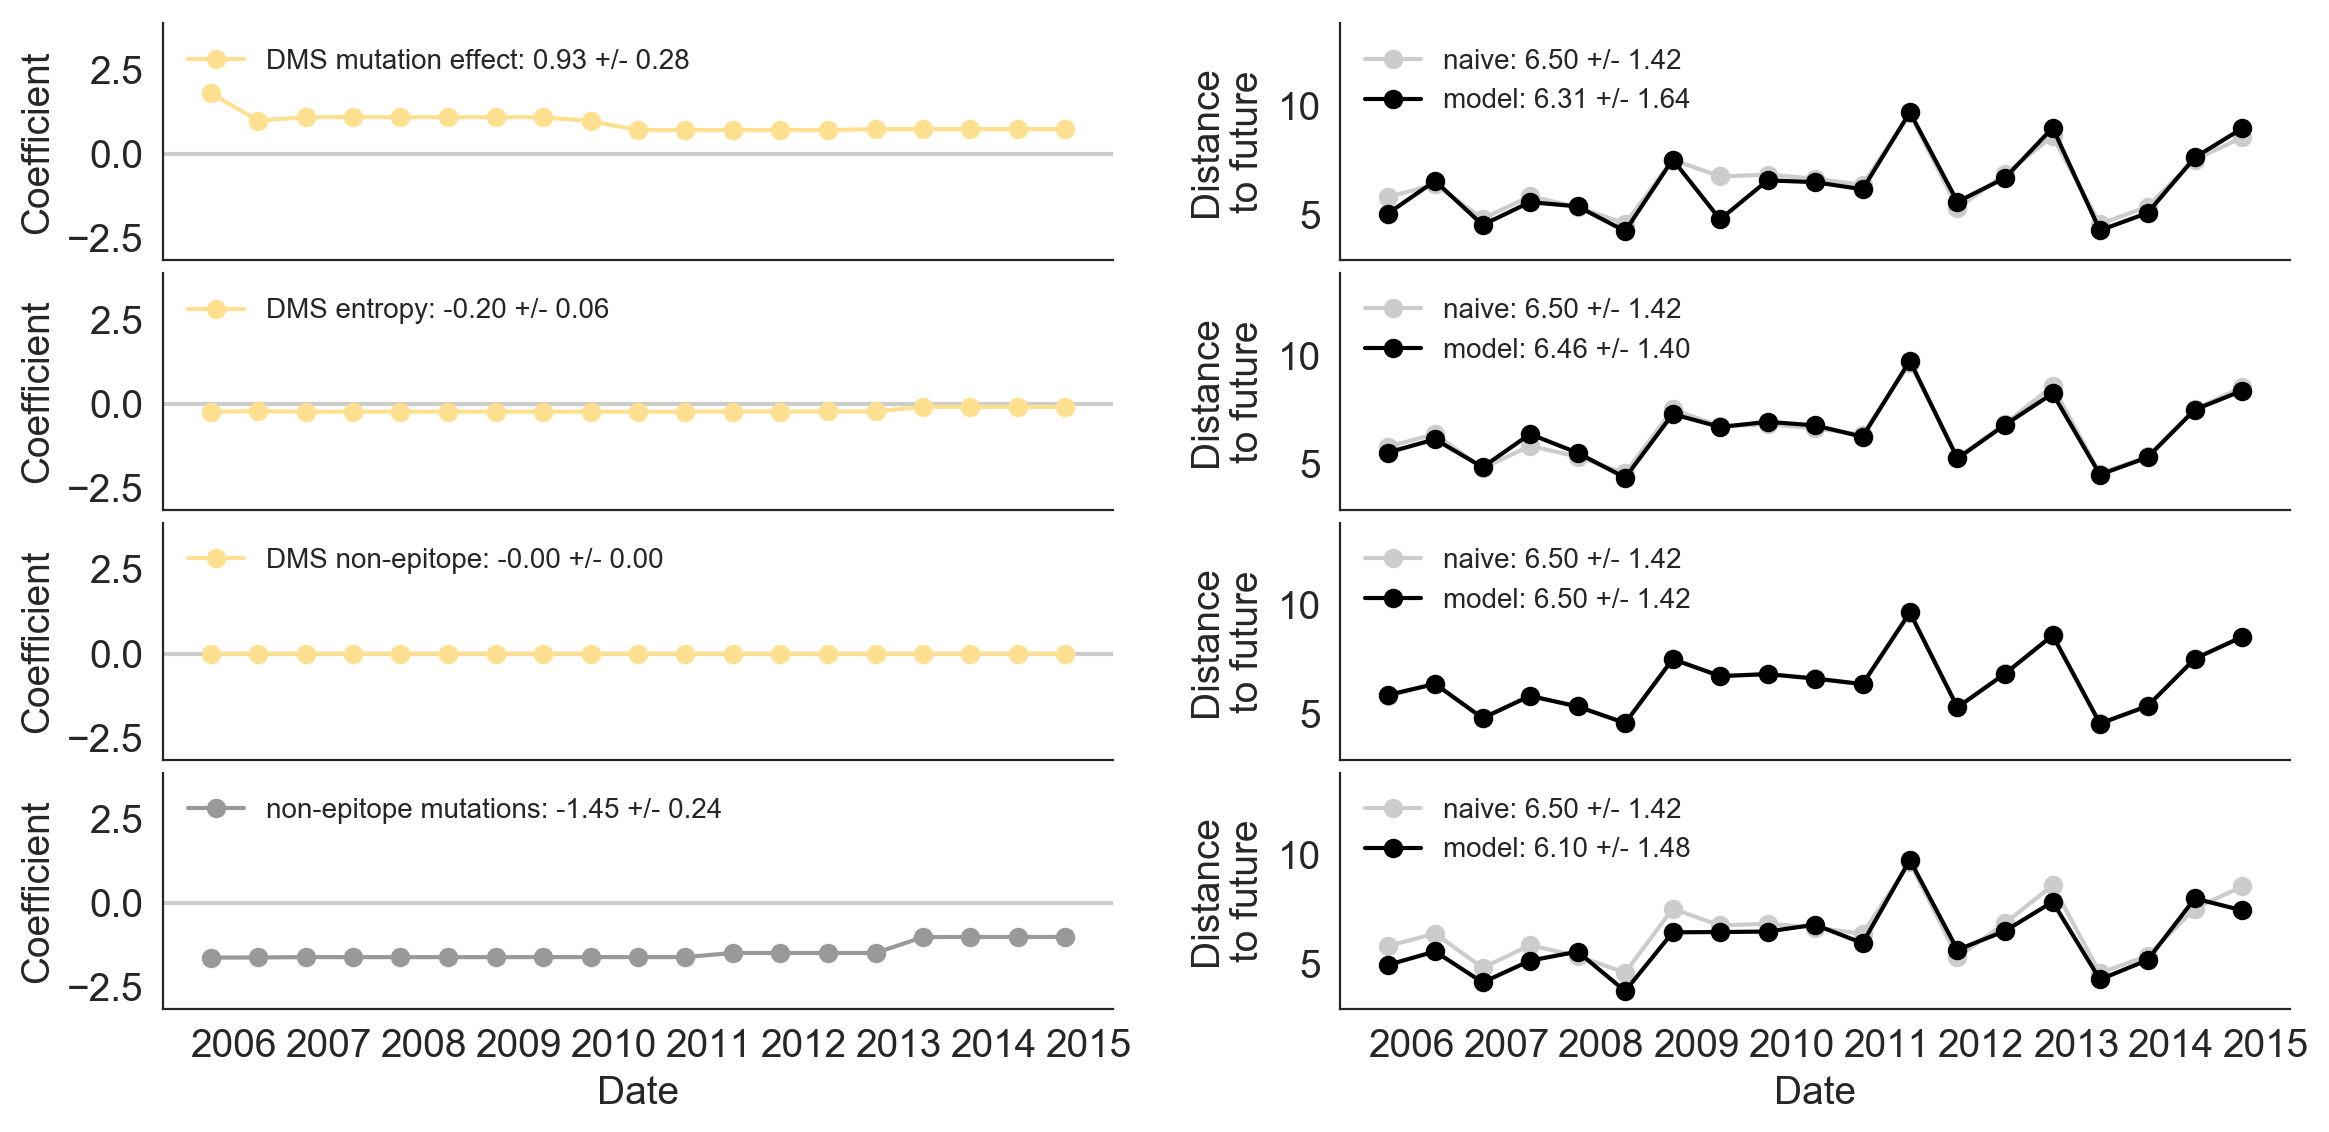

In [335]:
fig, axes, gs = plot_accuracy_and_coefficients_for_build(
    natural_errors_by_time_df,
    natural_coefficients_by_time_df,
    ["dms_star", "dms_entropy", "dms_nonepitope", "ne_star"],
    height=6,
    rotation=0
)
plt.savefig("../manuscript/figures/unadjusted-DMS-model-accuracy-and-coefficients-for-natural-populations.png")

#### All categories

In [ ]:
within_category_composite_predictors = [
    "ep_x-cTiter_x",
    "ne_star-dms_star",
    "lbi-delta_frequency"
]

In [ ]:
fig, axes, gs = plot_accuracy_and_coefficients_for_build(
    natural_errors_by_time_df,
    natural_coefficients_by_time_df,
    within_category_composite_predictors,
    height=6,
    text_vertical_padding=0.15
)
plt.savefig("../manuscript/figures/within-category-composite-unadjusted-model-accuracy-and-coefficients-for-natural-populations.png")

### Composite models

In [328]:
composite_models = [
    "cTiter_x-ne_star",
    "ne_star-lbi",
    "cTiter_x-ne_star-lbi"
]

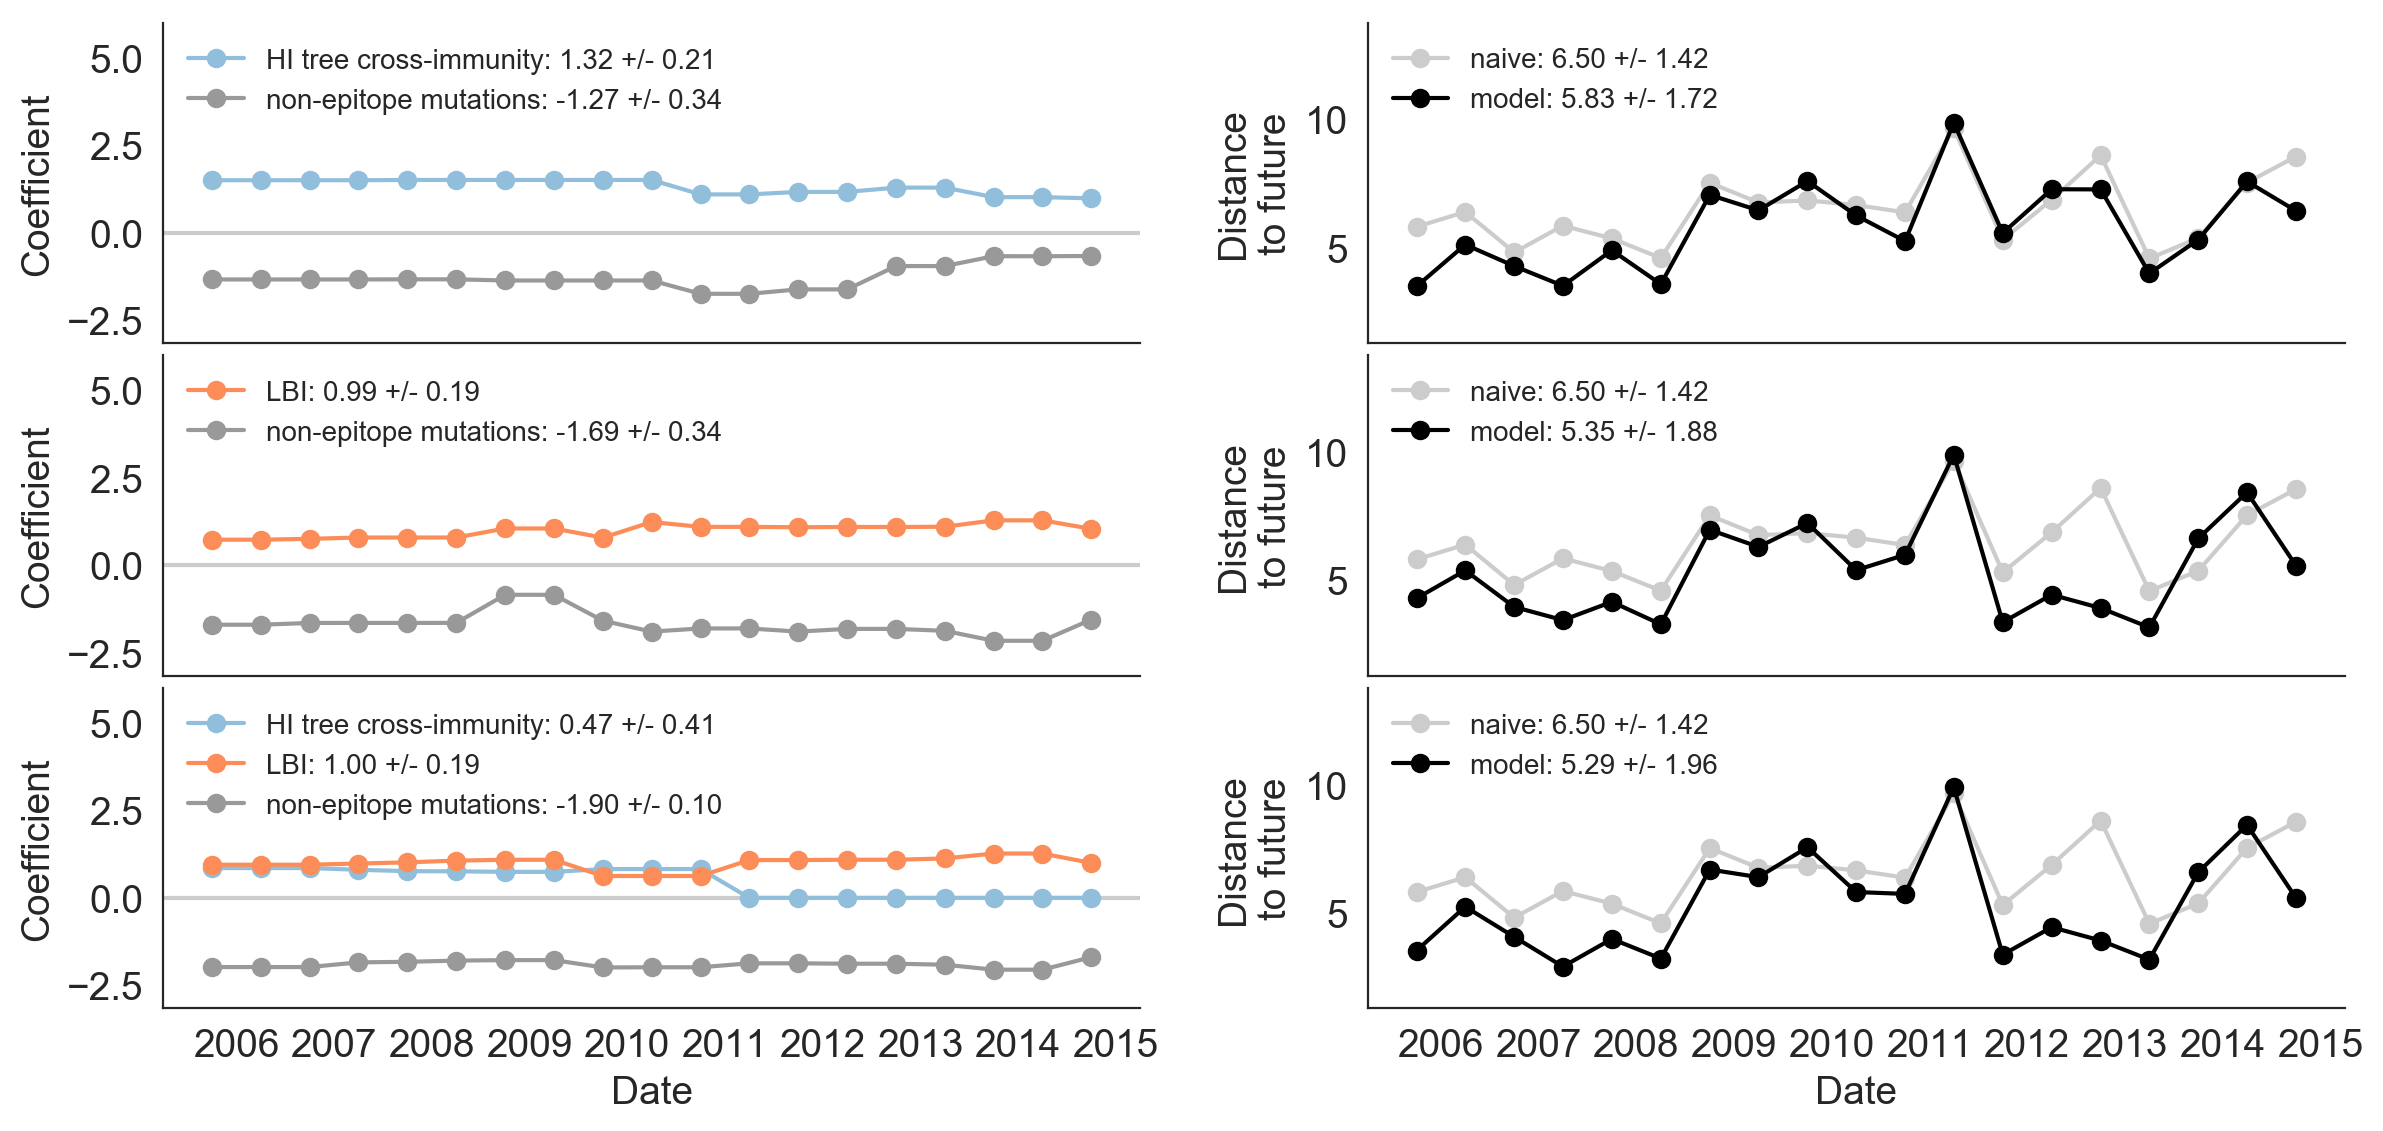

In [370]:
fig, axes, gs = plot_accuracy_and_coefficients_for_build(
    natural_errors_by_time_df,
    natural_coefficients_by_time_df,
    composite_models,
    height=6,
    text_vertical_padding=0.12,
    max_coefficient=6,
    rotation=0
)
plt.savefig("../manuscript/figures/best-composite-unadjusted-model-accuracy-and-coefficients-for-natural-populations.png")

### Best three-metric composite models

In [ ]:
best_three_metric_model = [
    "lbi-cTiter_x-ne_star",
    "delta_frequency-cTiter_x-ne_star"
]

In [ ]:
fig, axes, gs = plot_accuracy_and_coefficients_for_build(
    natural_errors_by_time_df,
    natural_coefficients_by_time_df,
    best_three_metric_model,
    height=5
)
#plt.savefig("../manuscript/figures/best-three-metric-unadjusted-model-accuracy-and-coefficients-for-natural-populations.png")

In [ ]:
naive_error_df.head()

In [ ]:
naive_error_df.tail()

Calculate sum of differences between the estimated distances from the naive model and each biological model. The higher sum per model, the more the biological model outperforms the naive model.

In [ ]:
naive_error_df = errors_by_time_df[errors_by_time_df["predictors"] == "naive"].copy()

In [ ]:
natural_errors_by_time_with_naive_df = natural_errors_by_time_df.merge(
    naive_error_df,
    on=["validation_timepoint", "validation_n", "type", "sample"],
    suffixes=["_model", "_naive"]
)

In [ ]:
natural_errors_by_time_with_naive_df["model_gain"] = (
    natural_errors_by_time_with_naive_df["validation_error_naive"] - natural_errors_by_time_with_naive_df["validation_error_model"]
)

In [ ]:
natural_errors_by_time_with_naive_df.head()

In [ ]:
natural_errors_by_time_with_naive_df.groupby("predictors_model")["model_gain"].sum().sort_values(ascending=False)

## Figure 4: Summary of models for Luksza and Lassig populations

In [ ]:
fig, axes, gs = plot_accuracy_and_coefficients_for_build(
    luksza_errors_by_time_df,
    luksza_coefficients_by_time_df,
    get_individual_predictors_for_data_frame(luksza_errors_by_time_df),
    height=6
)
#plt.savefig("../manuscript/figures/unadjusted-model-accuracy-and-coefficients-for-luksza-lassig-populations.png")

In [ ]:
fig, axes, gs = plot_accuracy_and_coefficients_for_build(
    luksza_errors_by_time_df,
    luksza_coefficients_by_time_df,
    ["lbi", "ep_x", "ne_star"] + get_composite_predictors_for_data_frame(luksza_errors_by_time_df)
)
#plt.savefig("../manuscript/figures/unadjusted-composite-model-accuracy-and-coefficients-for-luksza-lassig-populations.png")